# **Universidad de los Andes**

## Facultad de Ingeniería  
## Departamento de Ingeniería Biomédica

### Curso: IBIO 3270 - Diseño de Experimentos y Bioestadística

#### Oranización de los datos  
**Semestre:** 2025-1

---

**Diseñado por:** Cristian F. Rodríguez


### **Objetivo de la Sesión**

- Comprender los fundamentos de la **estadística descriptiva multivariante**, y su importancia en el análisis de datos biomédicos.
- Aprender a **visualizar y explorar datos multivariantes** mediante herramientas gráficas y numéricas.
- Identificar patrones, relaciones y posibles **outliers** en conjuntos de datos con múltiples variables.
- Aplicar los conceptos aprendidos a un **caso práctico realista**: la caracterización de **Carbon Dots (CDs)** fluorescentes para aplicaciones biomédicas, utilizando técnicas de síntesis controladas y variables experimentales relevantes.
- Generar gráficos y análisis que permitan **tomar decisiones experimentales fundamentadas**, un aspecto clave en diseño de experimentos y bioestadística para ingeniería biomédica.



In [53]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# --- Configuración del Estilo Gráfico ---
sns.set_theme(
    style="whitegrid",
    palette="Blues_d",
    context="notebook",
    font_scale=1.1
)

# --- Paleta de Colores Personalizada ---
mapa_colores = {
    'Panela': '#483D8B',  # Azul oscuro/morado
    'Café':   '#208A8C',  # Teal/Cian
    'Cerveza':'#78C2A4'   # Verde claro/menta
}




##  **1. Caso de Estudio: Síntesis y Caracterización de Carbon Dots (CDs)**

En esta sesión trabajaremos con datos simulados de un proceso de síntesis de **Carbon Dots (CDs)**, nanomateriales fluorescentes con alto potencial para aplicaciones biomédicas como diagnóstico temprano de enfermedades neurodegenerativas.

Los CDs se sintetizan en un **reactor microfluídico**, que permite un control preciso de las condiciones experimentales. Analizaremos cómo distintos factores de proceso afectan sus propiedades ópticas y físicas, buscando responder preguntas clave para la ingeniería biomédica:

- ¿Qué fuente de carbono produce CDs más brillantes?
- ¿Existe relación entre el tamaño de los CDs y el color que emiten?
- ¿Cómo influyen temperatura y tiempo de residencia en sus características finales?

### **Variables del Estudio**

- **Factor Principal (Categórico):**  
  - `Fuente_Carbono` → `'Café'`, `'Panela'`, `'Cerveza'`

- **Variables de Proceso (Entradas):**  
  - `Temperatura_Reaccion` (°C)  
  - `Tiempo_Residencia` (segundos)

- **Variables de Respuesta (Salidas):**  
  - `Diametro_CD` (nm) → Tamaño de la nanopartícula  
  - `Longitud_Onda_Emision` (nm) → Pico de emisión de fluorescencia  
  - `Rendimiento_Cuantico` (%) → Brillo relativo de los CDs

Nuestro objetivo es explorar este conjunto de datos de forma multivariante, identificando patrones y relaciones que permitan optimizar el proceso y tomar decisiones informadas en contextos de bioingeniería.



In [54]:

# --- Generación de Datos Sintéticos ---
np.random.seed(42)
n_muestras = 150

# Asignación de la fuente de carbono
fuentes = ['Café'] * 50 + ['Panela'] * 50 + ['Cerveza'] * 50
np.random.shuffle(fuentes)

# Variables de proceso
temperatura = np.random.uniform(160, 240, n_muestras)
tiempo_residencia = np.random.uniform(30, 300, n_muestras)

# Efecto de la fuente en el tamaño
efecto_tamano = np.array([
    6 if f == 'Panela' else -2 if f == 'Café' else 0
    for f in fuentes
])

# Diámetro de los Carbon Dots
# Incluye interacción T x tiempo
diametro_cd = (
    4
    + 0.02 * (temperatura - 160)
    + 0.008 * tiempo_residencia
    + 0.0001 * (temperatura - 160) * tiempo_residencia
    + efecto_tamano
    + np.random.normal(0, 0.8, n_muestras)
)

# Clipping físico: CDs no menores a 2 nm ni mayores a 12 nm
diametro_cd = np.clip(diametro_cd, 2, 15)

# Longitud de onda de emisión
longitud_onda = (
    440
    + 40 * np.log(diametro_cd)
    + 0.5 * (temperatura - 200)
    + np.random.normal(0, 8, n_muestras)
)

# Clipping físico: visible light range
longitud_onda = np.clip(longitud_onda, 420, 650)

# Efecto de la fuente en el rendimiento cuántico
efecto_qy = np.array([
    15 if f == 'Panela' else -10 if f == 'Cerveza' else 0
    for f in fuentes
])

# Rendimiento cuántico (%)
# Gaussian peak around 200°C
QY_max = 45
sigma_T = 20

rendimiento_cuantico = (
    QY_max * np.exp(- ((temperatura - 200)**2) / (2 * sigma_T**2))
    - 1.5 * (diametro_cd - 4)
    + 0.01 * tiempo_residencia
    - 0.00002 * (tiempo_residencia**2)
    + efecto_qy
    + np.random.normal(0, 5, n_muestras)
)

# Clipping físico
rendimiento_cuantico = np.clip(rendimiento_cuantico, 5, 80)

# Armado del DataFrame
df = pd.DataFrame({
    'Fuente_Carbono': fuentes,
    'Temperatura_Reaccion': temperatura.round(1),
    'Tiempo_Residencia': tiempo_residencia.round(1),
    'Diametro_CD': diametro_cd.round(2),
    'Longitud_Onda_Emision': longitud_onda.round(2),
    'Rendimiento_Cuantico': rendimiento_cuantico.round(2)
})

# Inspección inicial
print("Primeras 5 filas del conjunto de datos:")
display(df.head())

Primeras 5 filas del conjunto de datos:


Fuente_Carbono  Temperatura_Reaccion  Tiempo_Residencia  Diametro_CD  \
0         Panela                 179.9              180.3        12.01   
1           Café                 192.8              282.8         6.53   
2        Cerveza                 220.4              217.9         8.05   
3         Panela                 178.3              183.9        11.68   
4         Panela                 166.2               56.2        12.14   

   Longitud_Onda_Emision  Rendimiento_Cuantico  
0                 548.39                 32.44  
1                 508.99                 41.84  
2                 528.65                 13.09  
3                 509.94                 23.92  
4                 529.74                  7.34


## **2. Medidas Descriptivas Numéricas**

Antes de visualizar los datos, es fundamental entenderlos numéricamente. En este bloque calcularemos:

- El **vector de medias**, que nos indica el valor promedio de cada variable en el conjunto de datos.
- El **vector de desviaciones estándar**, para conocer la variabilidad de cada variable.
- Las **medias y desviaciones estándar agrupadas** por `Fuente_Carbono`, para comparar si existen diferencias entre Panela, Café y Cerveza.
- La **matriz de correlaciones**, que nos ayuda a identificar relaciones lineales entre pares de variables, clave en análisis multivariante.  
  Por ejemplo, si el diámetro de los Carbon Dots se relaciona con la longitud de onda que emiten.

Estas medidas serán la base para interpretar los gráficos que construiremos después.



In [55]:
# ---------------------------------------------
# Variables numéricas a analizar
# ---------------------------------------------
variables_numericas = [
    'Temperatura_Reaccion',
    'Tiempo_Residencia',
    'Diametro_CD',
    'Longitud_Onda_Emision',
    'Rendimiento_Cuantico'
]

# --- Vector de medias ---
print("--- Vector de Medias ---")
print(df[variables_numericas].mean().round(2))

# --- Vector de desviaciones estándar ---
print("\n--- Vector de Desviaciones Estándar ---")
print(df[variables_numericas].std().round(2))

# --- Medias agrupadas por Fuente_Carbono ---
print("\n--- Medias por Fuente de Carbono ---")
print(df.groupby('Fuente_Carbono')[variables_numericas].mean().round(2))

# --- Desviaciones estándar agrupadas por Fuente_Carbono ---
print("\n--- Desviaciones Estándar por Fuente de Carbono ---")
print(df.groupby('Fuente_Carbono')[variables_numericas].std().round(2))

# --- Matriz de correlaciones ---
print("\n--- Matriz de Correlaciones ---")
matriz_corr = df[variables_numericas].corr()
display(matriz_corr.round(2))


--- Vector de Medias ---
Temperatura_Reaccion     200.11
Tiempo_Residencia        166.28
Diametro_CD                8.19
Longitud_Onda_Emision    519.47
Rendimiento_Cuantico      23.26
dtype: float64

--- Vector de Desviaciones Estándar ---
Temperatura_Reaccion     23.71
Tiempo_Residencia        78.28
Diametro_CD               3.68
Longitud_Onda_Emision    27.46
Rendimiento_Cuantico     13.97
dtype: float64

--- Medias por Fuente de Carbono ---
                Temperatura_Reaccion  Tiempo_Residencia  Diametro_CD  \
Fuente_Carbono                                                         
Café                          198.37             157.46         4.79   
Cerveza                       205.27             169.97         7.07   
Panela                        196.69             171.41        12.71   

                Longitud_Onda_Emision  Rendimiento_Cuantico  
Fuente_Carbono                                               
Café                           497.81                 26.82  
Cerv

Temperatura_Reaccion  Tiempo_Residencia  Diametro_CD  \
Temperatura_Reaccion                   1.00               0.00         0.19   
Tiempo_Residencia                      0.00               1.00         0.31   
Diametro_CD                            0.19               0.31         1.00   
Longitud_Onda_Emision                  0.61               0.24         0.81   
Rendimiento_Cuantico                  -0.16              -0.06         0.13   

                       Longitud_Onda_Emision  Rendimiento_Cuantico  
Temperatura_Reaccion                    0.61                 -0.16  
Tiempo_Residencia                       0.24                 -0.06  
Diametro_CD                             0.81                  0.13  
Longitud_Onda_Emision                   1.00                 -0.01  
Rendimiento_Cuantico                   -0.01                  1.00

### **3. Heatmap de Correlaciones**

Hemos calculado la matriz de correlaciones numéricamente, pero es mucho más informativo **visualizarla gráficamente**.

Un **heatmap de correlaciones** nos permite:

- Identificar rápidamente **pares de variables altamente correlacionadas**, ya sea de forma positiva o negativa.
- Detectar posibles **multicolinealidades**, es decir, variables que contienen información redundante.
- Explorar relaciones que podrían ser interesantes para futuros análisis multivariantes.

---

#### **¿Qué es la matriz de correlación?**

La **matriz de correlación** es una tabla cuadrada que resume el grado de relación **lineal** entre todas las variables numéricas de un conjunto de datos.

Cada celda de la matriz contiene un valor de **coeficiente de correlación de Pearson** entre dos variables \( X \) y \( Y \).

La fórmula es:

$$
\rho_{X,Y} = \frac{\mathrm{Cov}(X,Y)}{\sigma_X \cdot \sigma_Y}
$$

donde:

- $\mathrm{Cov}(X,Y)$ es la covarianza entre \( X \) y \( Y \).
- $\sigma_X$, $\sigma_Y$ son las desviaciones estándar de \( X \) y \( Y \).

---

#### **Interpretación del coeficiente de correlación**

- Si $\rho_{X,Y} = 1$, existe **correlación positiva perfecta**: las dos variables crecen o decrecen juntas.
- Si $\rho_{X,Y} = -1$, existe **correlación negativa perfecta**: una variable crece mientras la otra decrece.
- Si $\rho_{X,Y} = 0$, **no existe relación lineal** entre las variables.

**Es importante recordar:** la correlación de Pearson mide **solo relaciones lineales**. Otras relaciones no lineales pueden no reflejarse en esta matriz.

---

#### **Importancia en Bioingeniería**

En bioingeniería, entender las correlaciones entre variables es fundamental para:

- **Interpretar experimentos** (por ejemplo, cómo la temperatura afecta el tamaño de partículas).
- **Reducir dimensionalidad** (seleccionar solo variables no redundantes).
- Evitar problemas en modelos predictivos, como **multicolinealidad**.

---

#### **Correlaciones en nuestro caso de estudio**

Para el caso de los **Carbon Dots**, podría interesarnos analizar correlaciones como:

- Entre el **diámetro de los Carbon Dots** y su **longitud de onda de emisión**, debido al efecto de confinamiento cuántico.
- Entre las condiciones de síntesis (temperatura, tiempo) y el rendimiento cuántico.

Vamos a graficar el **heatmap de correlaciones** usando nuestro dataset.


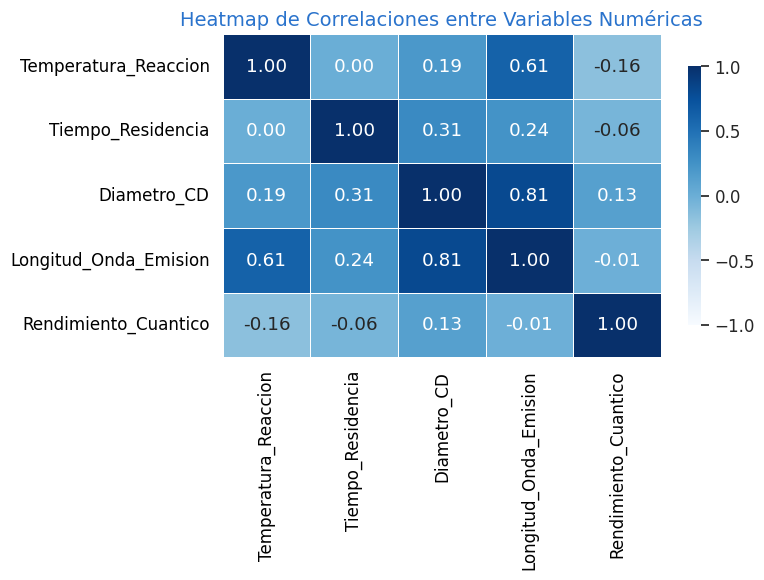

In [56]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Variables numéricas de interés
variables_numericas = [
    'Temperatura_Reaccion',
    'Tiempo_Residencia',
    'Diametro_CD',
    'Longitud_Onda_Emision',
    'Rendimiento_Cuantico'
]

# Calculamos la matriz de correlación
corr_matrix = df[variables_numericas].corr()

# Creamos el heatmap con estética azul
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='Blues',
    vmin=-1,
    vmax=1,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title('Heatmap de Correlaciones entre Variables Numéricas', color='#2A73CC', fontsize=14)
plt.xticks(color='black')
plt.yticks(color='black')
plt.tight_layout()
plt.show()



## **3. Visualización Exploratoria de Datos (EDA)**

Una vez conocemos las medidas numéricas de nuestro conjunto de datos, es fundamental **verlas gráficamente** para descubrir patrones, tendencias, o datos atípicos que puedan estar ocultos en las tablas.

En este bloque aprenderemos a:

- Visualizar la distribución de variables individuales (**análisis univariante**).
- Comparar variables entre diferentes grupos (**análisis bivariante**).
- Identificar relaciones entre pares de variables.
- Explorar la estructura multivariante de los datos.

Comenzaremos con **histogramas**, que nos ayudan a ver la forma de las distribuciones de cada variable, su simetría, su dispersión y la posible presencia de múltiples modos o valores atípicos.

¡Todo esto aplicado al caso real de síntesis de Carbon Dots en bioingeniería!


### **3.1 Histogramas Univariantes**

Los histogramas son una herramienta básica para observar cómo se distribuyen los valores de una variable. Nos permiten detectar:

- Asimetría en la distribución.
- Presencia de valores extremos o atípicos.
- Distribuciones multimodales.
- Concentración de datos en ciertos rangos.

Comencemos visualizando la distribución de variables clave del proceso de síntesis de Carbon Dots.


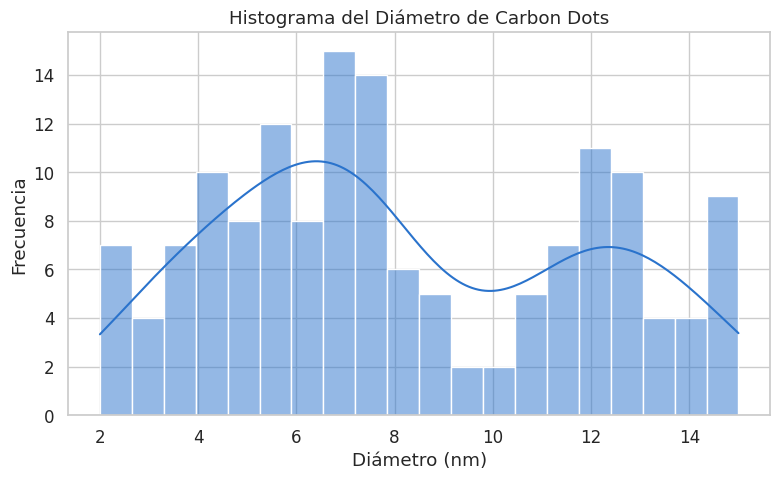

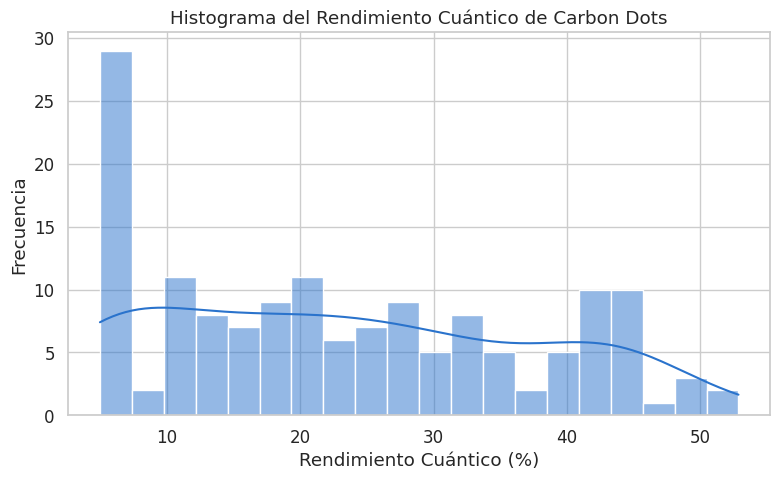

In [57]:
# --------------------------------------------------------
# Histograma de Diametro_CD
# --------------------------------------------------------
plt.figure(figsize=(8,5))
sns.histplot(df['Diametro_CD'], bins=20, kde=True, color="#2A73CC")
plt.title('Histograma del Diámetro de Carbon Dots')
plt.xlabel('Diámetro (nm)')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

# --------------------------------------------------------
# Histograma de Rendimiento_Cuantico
# --------------------------------------------------------
plt.figure(figsize=(8,5))
sns.histplot(df['Rendimiento_Cuantico'], bins=20, kde=True, color="#2A73CC")
plt.title('Histograma del Rendimiento Cuántico de Carbon Dots')
plt.xlabel('Rendimiento Cuántico (%)')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()


Podemos observar, por ejemplo:

- Si los diámetros de los Carbon Dots tienden a agruparse en un rango específico.
- Si el rendimiento cuántico muestra asimetría o múltiples picos, lo cual podría indicar la influencia de distintos precursores o condiciones de síntesis.

Estos patrones nos orientarán en los análisis comparativos que haremos a continuación.


### **3.2 Histogramas Comparativos por Grupo**

Ahora vamos a comparar las distribuciones de variables clave **entre las diferentes fuentes de carbono**.

Superponer histogramas para cada grupo nos permite:

- Identificar si alguna fuente produce Carbon Dots con propiedades significativamente distintas.
- Observar posibles solapamientos entre grupos.
- Detectar diferencias en dispersión o asimetría.

Comenzaremos comparando el **Diámetro de los Carbon Dots** y el **Rendimiento Cuántico**, variables fundamentales en aplicaciones biomédicas.


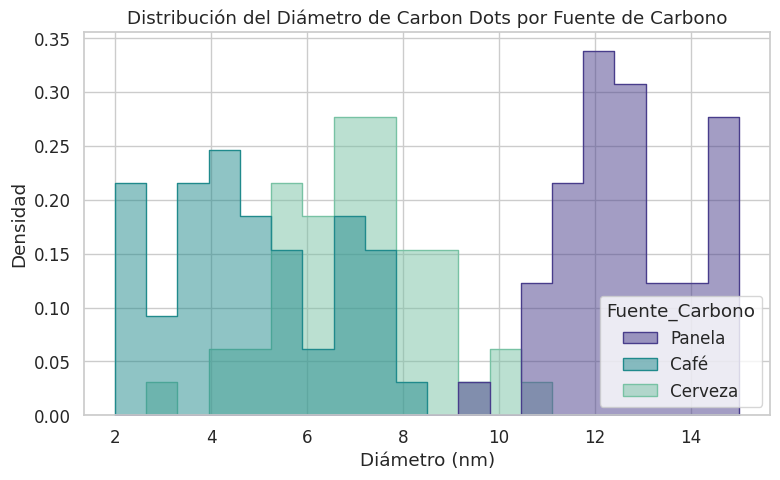

In [58]:
plt.figure(figsize=(8,5))
sns.histplot(
    data=df,
    x='Diametro_CD',
    hue='Fuente_Carbono',
    element='step',
    stat='density',
    common_norm=False,
    palette=mapa_colores,
    bins=20,
    alpha=0.5
)

plt.title('Distribución del Diámetro de Carbon Dots por Fuente de Carbono')
plt.xlabel('Diámetro (nm)')
plt.ylabel('Densidad')
plt.tight_layout()
plt.show()


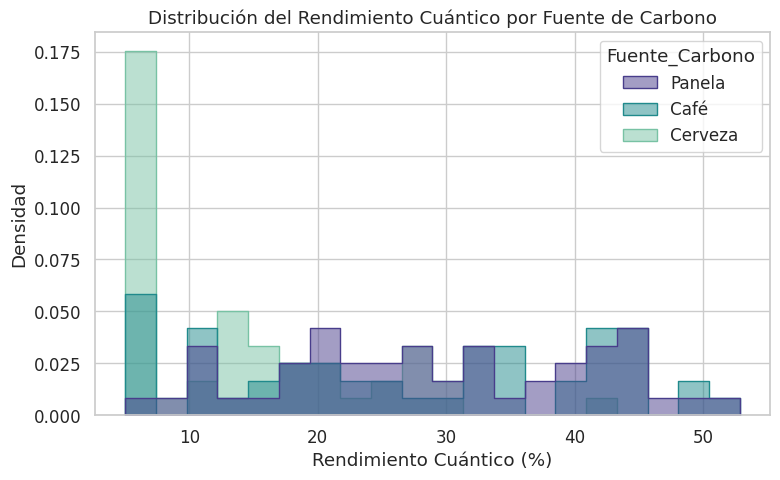

In [59]:
plt.figure(figsize=(8,5))
sns.histplot(
    data=df,
    x='Rendimiento_Cuantico',
    hue='Fuente_Carbono',
    element='step',
    stat='density',
    common_norm=False,
    palette=mapa_colores,
    bins=20,
    alpha=0.5
)

plt.title('Distribución del Rendimiento Cuántico por Fuente de Carbono')
plt.xlabel('Rendimiento Cuántico (%)')
plt.ylabel('Densidad')
plt.tight_layout()
plt.show()


Podemos observar, por ejemplo:

- Qué fuente produce Carbon Dots con diámetros más grandes o más pequeños.
- Si el rendimiento cuántico tiende a ser más alto en alguna fuente específica.
- Si existen solapamientos importantes entre grupos, lo cual podría dificultar clasificar los lotes de síntesis basados solo en estas variables.

Estas diferencias visuales nos preparan para analizar estos mismos datos con herramientas como **boxplots**, que permiten cuantificar más claramente las diferencias entre grupos.


### **3.3 Fundamentos de la Estimación de Densidad y los Kernels**

Después de estudiar los histogramas, surge una pregunta fundamental en análisis de datos:

> ¿Existe una manera de estimar la forma de la distribución de los datos, de manera suave y continua, sin depender de intervalos arbitrarios como los bins de un histograma?

La respuesta es **sí**, y se basa en una técnica llamada **Estimación de Densidad Kernel (KDE)**.

---

#### **¿Qué es una estimación de densidad?**

En estadística, la función de densidad de probabilidad (PDF) describe **cómo se distribuyen los datos a lo largo de sus valores posibles**. Si conociéramos la PDF verdadera de una variable, podríamos entender completamente su comportamiento probabilístico.

Sin embargo, en la práctica casi nunca conocemos esa función verdadera. Lo que tenemos son **muestras de datos** y queremos **estimar cómo se distribuyen**.

---

#### **Limitaciones del histograma**

Un histograma es la forma más simple de estimar una densidad:

- Divide el eje en intervalos (bins).
- Cuenta cuántos datos caen en cada intervalo.
- Dibuja barras proporcionales a esas frecuencias.

**Problemas del histograma:**

- Su forma depende fuertemente de la elección de los bins (anchura y posición).
- Tiene bordes bruscos y escalones.
- Puede ocultar características finas de la distribución.

---

#### **¿Qué es un kernel?**

Aquí es donde entran los **kernels**.

En esencia, un **kernel** es:

> **Una función matemática simétrica y suave que se usa como “peso” para estimar la densidad alrededor de cada punto de datos.**

Matemáticamente, un kernel $K(u)$ cumple:

- $K(u) \ge 0$ (es siempre positivo o cero)
- $\int_{-\infty}^{\infty} K(u) \, du = 1$ (su área total es 1)
- Suele ser máximo en $u = 0$, decreciendo hacia los lados.

---

#### **Cómo funciona la estimación de densidad kernel (KDE)**

La idea de la KDE es:

- Centrar un kernel sobre **cada punto de datos**.
- Sumarlos todos.
- Normalizar por el número de datos y el ancho del kernel.

La fórmula de la estimación de densidad kernel es:

$$
\hat{f}(x) = \frac{1}{n \cdot h} \sum_{i=1}^{n} K\left( \frac{x - x_i}{h} \right)
$$

donde:

- $x$ es el punto donde queremos estimar la densidad.
- $x_i$ son los datos observados.
- $K$ es la función kernel.
- $h$ es el parámetro **bandwidth** (ancho de suavizado).
- $n$ es el tamaño de la muestra.

---

#### **Interpretación geométrica**

- Cada dato $x_i$ aporta una **pequeña campana** centrada en $x_i$.
- Esas campanas tienen anchura $h$ y forma definida por el kernel.
- La suma de todas esas campanas forma una **curva suave**.

---

#### **Tipos de kernels**

Distintos kernels tienen formas distintas, pero todos cumplen las propiedades básicas:

- **Uniforme (Rectangular)**

  $$
  K(u) = \frac{1}{2} \cdot I(|u| \le 1)
  $$

- **Triangular**

  $$
  K(u) = (1 - |u|) \cdot I(|u| \le 1)
  $$

- **Epanechnikov**

  $$
  K(u) = \frac{3}{4}(1 - u^2) \cdot I(|u| \le 1)
  $$

- **Biweight (Quartic)**

  $$
  K(u) = \frac{15}{16}(1 - u^2)^2 \cdot I(|u| \le 1)
  $$

- **Gaussiano**

  $$
  K(u) = \frac{1}{\sqrt{2\pi}} e^{-\frac{u^2}{2}}
  $$

Donde $I(|u| \le 1)$ es la función indicadora, que vale 1 si $|u| \le 1$ y 0 en caso contrario.

---

#### **El parámetro Bandwidth ($h$)**

Un punto crucial en KDE es el parámetro **bandwidth $h$**:

- Si $h$ es muy pequeño:
  - La curva es muy irregular y se ajusta demasiado al ruido.
  - Riesgo de **overfitting**.
  
- Si $h$ es muy grande:
  - La curva se suaviza tanto que pierde detalles importantes.
  - Riesgo de **underfitting**.

La selección de $h$ es uno de los temas más importantes en la práctica.

---

#### **Importancia en Bioingeniería**

En bioingeniería y en análisis de materiales, la KDE se utiliza para:

- Estimar distribuciones de tamaño de nanopartículas.
- Analizar intensidad de fluorescencia.
- Estudiar la variabilidad de respuestas fisiológicas.

Frente al histograma, la KDE permite:

- Describir mejor la **forma real** de la distribución.
- Identificar multimodalidad (varios picos).
- Visualizar patrones que el histograma podría ocultar.

---

**En resumen:**

> Un **kernel** es una función que define la forma de las “pequeñas campanas” que se suman en la estimación de densidad. La KDE es una técnica que nos permite convertir un conjunto de datos en una **curva suave** que describe su distribución, superando las limitaciones del histograma.


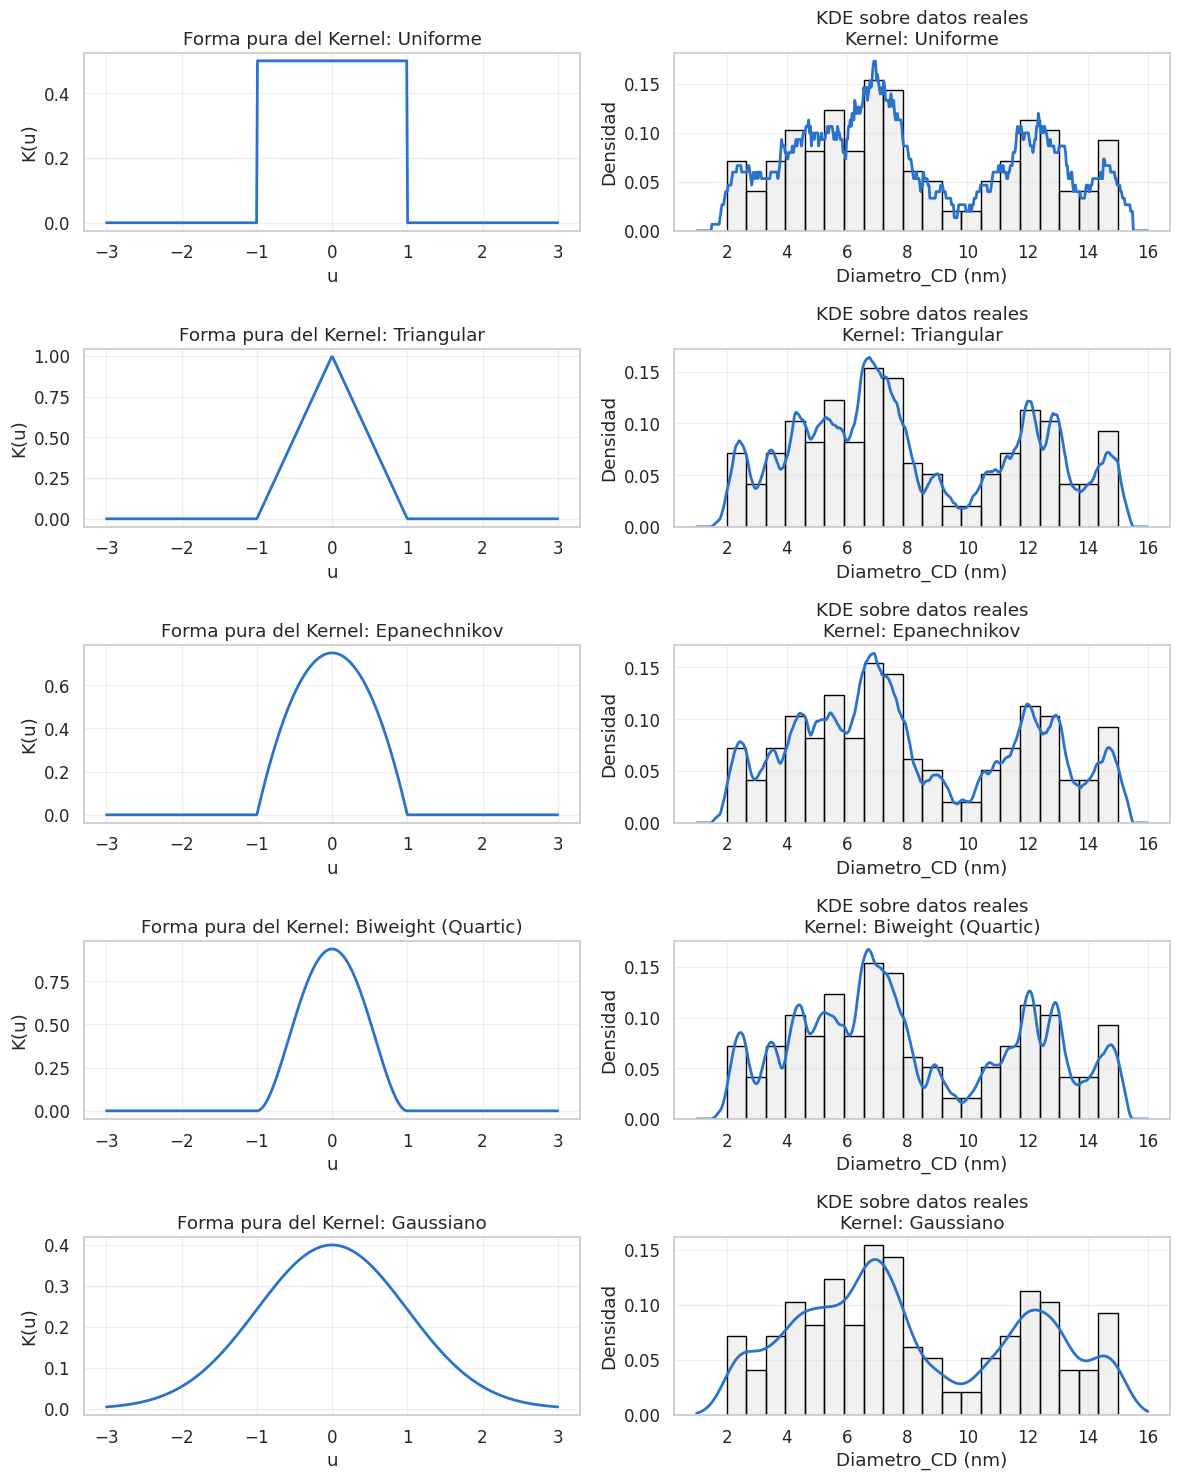

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Datos reales
x_data = df['Diametro_CD'].values

# Bandwidth
h = 0.5

# Grid para graficar kernel puro
u = np.linspace(-3, 3, 500)

# Grid para evaluar KDE sobre datos reales
x_grid = np.linspace(x_data.min() - 1, x_data.max() + 1, 500)

# Definición de kernels
kernels = {
    'Uniforme': lambda u: 0.5 * ((np.abs(u) <= 1).astype(float)),
    'Triangular': lambda u: (1 - np.abs(u)) * (np.abs(u) <= 1),
    'Epanechnikov': lambda u: 0.75 * (1 - u**2) * (np.abs(u) <= 1),
    'Biweight (Quartic)': lambda u: (15/16) * (1 - u**2)**2 * (np.abs(u) <= 1),
    'Gaussiano': lambda u: (1/np.sqrt(2*np.pi)) * np.exp(-0.5 * u**2)
}

# Número de kernels
n_kernels = len(kernels)

# Crear figura de subplots (dos columnas)
fig, axes = plt.subplots(
    nrows=n_kernels, ncols=2,
    figsize=(12, 3 * n_kernels)
)

for i, (kernel_name, K) in enumerate(kernels.items()):
    
    # ---------------------------------------------------
    # Plot del kernel puro
    # ---------------------------------------------------
    ax_left = axes[i, 0]
    
    ax_left.plot(u, K(u), color='#2A73CC', linewidth=2)
    ax_left.set_title(f'Forma pura del Kernel: {kernel_name}')
    ax_left.set_xlabel('u')
    ax_left.set_ylabel('K(u)')
    ax_left.grid(alpha=0.3)
    
    # ---------------------------------------------------
    # Plot KDE sobre datos reales
    # ---------------------------------------------------
    ax_right = axes[i, 1]
    
    # Histograma de fondo
    sns.histplot(
        x_data,
        bins=20,
        stat='density',
        color='lightgray',
        alpha=0.3,
        edgecolor='black',
        ax=ax_right
    )
    
    # Calcular KDE a mano
    U = (x_grid[:, None] - x_data[None, :]) / h
    K_values = K(U)
    density = K_values.sum(axis=1) / (len(x_data) * h)
    
    ax_right.plot(x_grid, density, color='#2A73CC', linewidth=2)
    ax_right.set_title(f'KDE sobre datos reales\nKernel: {kernel_name}')
    ax_right.set_xlabel('Diametro_CD (nm)')
    ax_right.set_ylabel('Densidad')
    ax_right.grid(alpha=0.3)

plt.tight_layout()
plt.show()


### **3.3 Boxplots Agrupados**

Los **boxplots** son una herramienta fundamental en análisis exploratorio porque permiten comparar rápidamente:

- La mediana de cada grupo.
- La dispersión de los datos (rango intercuartílico).
- La presencia de **outliers**, que pueden indicar lotes anómalos en el proceso de síntesis.

Aplicaremos esta técnica para comparar dos variables clave:

- **Diámetro de los Carbon Dots**, relacionado con sus propiedades ópticas.
- **Rendimiento Cuántico**, que indica la eficiencia de emisión de luz.

Esto nos permitirá ver claramente si alguna fuente de carbono produce CDs con características significativamente diferentes.

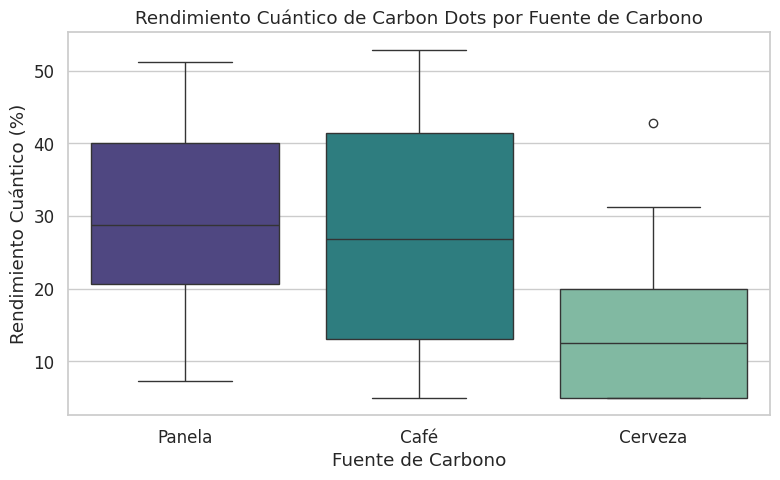

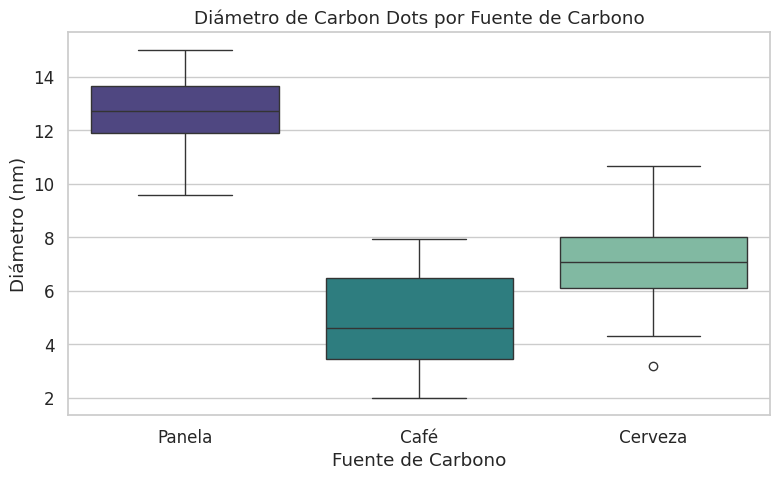

In [61]:
# --------------------------------------------------------
# Boxplot - Rendimiento Cuántico
# --------------------------------------------------------
fig, ax = plt.subplots(figsize=(8,5))
sns.boxplot(
    data=df,
    x='Fuente_Carbono',
    y='Rendimiento_Cuantico',
    hue='Fuente_Carbono',
    palette=mapa_colores,
    ax=ax
)
if ax.legend_ is not None:
    ax.legend_.remove()
ax.set_title('Rendimiento Cuántico de Carbon Dots por Fuente de Carbono')
ax.set_xlabel('Fuente de Carbono')
ax.set_ylabel('Rendimiento Cuántico (%)')
plt.tight_layout()
plt.show()

# --------------------------------------------------------
# Boxplot - Diámetro
# --------------------------------------------------------
fig, ax = plt.subplots(figsize=(8,5))
sns.boxplot(
    data=df,
    x='Fuente_Carbono',
    y='Diametro_CD',
    hue='Fuente_Carbono',
    palette=mapa_colores,
    ax=ax
)
if ax.legend_ is not None:
    ax.legend_.remove()
ax.set_title('Diámetro de Carbon Dots por Fuente de Carbono')
ax.set_xlabel('Fuente de Carbono')
ax.set_ylabel('Diámetro (nm)')
plt.tight_layout()
plt.show()



A partir de los boxplots podemos observar:

- **Diámetro de los Carbon Dots:**
  - Si alguna fuente de carbono produce CDs sistemáticamente más grandes o más pequeños.
  - Si existe mayor variabilidad en algún precursor, lo cual podría reflejar menor control en el proceso de síntesis.

- **Rendimiento Cuántico:**
  - Qué fuente de carbono logra CDs más brillantes en promedio.
  - Si existen lotes con rendimientos muy bajos o altos, que podrían indicar condiciones experimentales fuera de control.

Los boxplots son ideales para **detectar outliers**, datos que se alejan mucho de la distribución central, fundamentales en el control de calidad en procesos de ingeniería biomédica.


### **3.4 Density Plots Univariantes**

Además de los histogramas, otra forma de visualizar distribuciones es mediante las **curvas de densidad kernel (KDE)**. Estas curvas suavizan la distribución de datos y nos permiten ver patrones como:

- La forma general de la distribución (asimetría, multimodalidad).
- Diferencias entre grupos.
- Áreas de mayor o menor concentración de datos.

La ventaja frente a los histogramas es que **no dependen de bins**, sino de un parámetro llamado **bandwidth**, que controla cuánta suavización se aplica.

A continuación, graficaremos las curvas de densidad para el **diámetro** y el **rendimiento cuántico** de los Carbon Dots, diferenciando las fuentes de carbono.


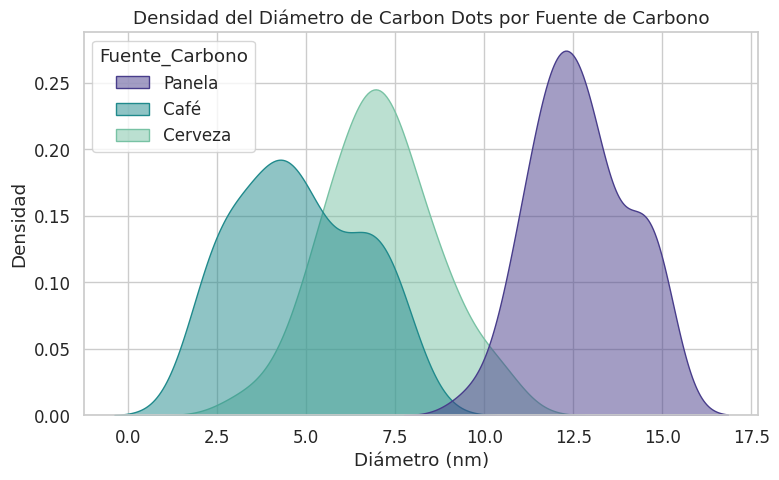

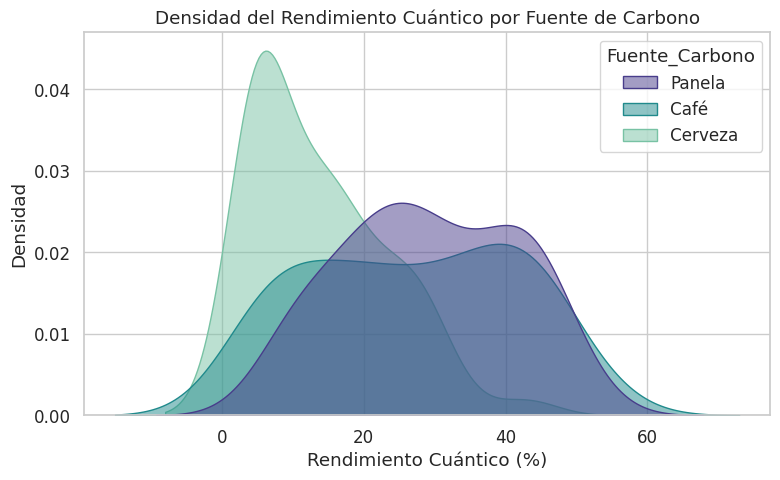

In [62]:
# --------------------------------------------------------
# Density plot - Diametro
# --------------------------------------------------------
plt.figure(figsize=(8,5))
sns.kdeplot(
    data=df,
    x='Diametro_CD',
    hue='Fuente_Carbono',
    fill=True,
    common_norm=False,
    palette=mapa_colores,
    alpha=0.5
)
plt.title('Densidad del Diámetro de Carbon Dots por Fuente de Carbono')
plt.xlabel('Diámetro (nm)')
plt.ylabel('Densidad')
plt.tight_layout()
plt.show()

# --------------------------------------------------------
# Density plot - Rendimiento Cuántico
# --------------------------------------------------------
plt.figure(figsize=(8,5))
sns.kdeplot(
    data=df,
    x='Rendimiento_Cuantico',
    hue='Fuente_Carbono',
    fill=True,
    common_norm=False,
    palette=mapa_colores,
    alpha=0.5
)
plt.title('Densidad del Rendimiento Cuántico por Fuente de Carbono')
plt.xlabel('Rendimiento Cuántico (%)')
plt.ylabel('Densidad')
plt.tight_layout()
plt.show()


A partir de estas curvas podemos observar:

- Si alguna fuente de carbono produce Carbon Dots con distribuciones claramente distintas en diámetro o rendimiento cuántico.
- Si existen **modos múltiples** (varios picos), lo cual puede indicar sub-poblaciones de partículas.
- Si la variabilidad es más amplia en alguno de los grupos, reflejando procesos menos controlados.

Las densidades kernel son una herramienta fundamental para entender la **forma exacta de las distribuciones**, algo que a veces los histogramas pueden ocultar.


### **3.5 Scatterplots**

Los **scatterplots** o diagramas de dispersión nos permiten analizar visualmente la relación entre dos variables cuantitativas. Son especialmente útiles para:

- Detectar patrones lineales o no lineales.
- Identificar posibles agrupaciones o clusters.
- Detectar **outliers bivariantes**, es decir, puntos que no siguen la tendencia general.

En el caso de los Carbon Dots, una relación clave es la existente entre el **Diámetro de las partículas** y la **Longitud de onda de emisión**:

- En física, se conoce como **efecto de confinamiento cuántico**: partículas más grandes tienden a emitir en longitudes de onda más largas (hacia el rojo).
- Partículas más pequeñas emiten en longitudes de onda más cortas (hacia el azul).

Vamos a graficar esta relación, primero sin diferenciar grupos y luego coloreando cada grupo según la fuente de carbono utilizada.


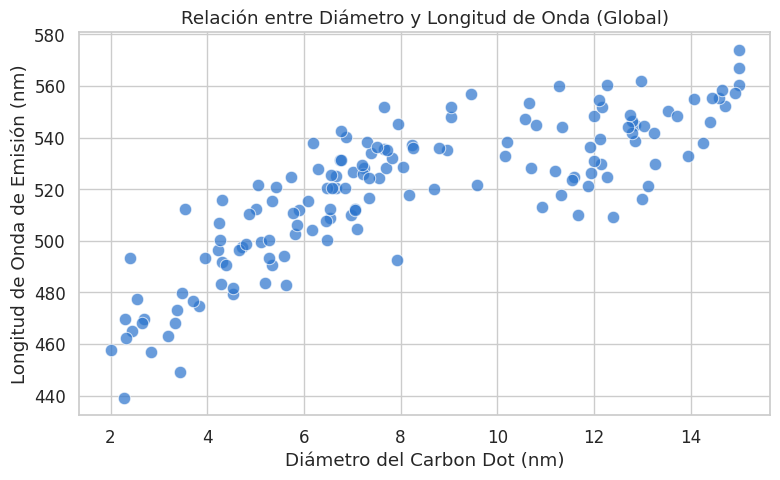

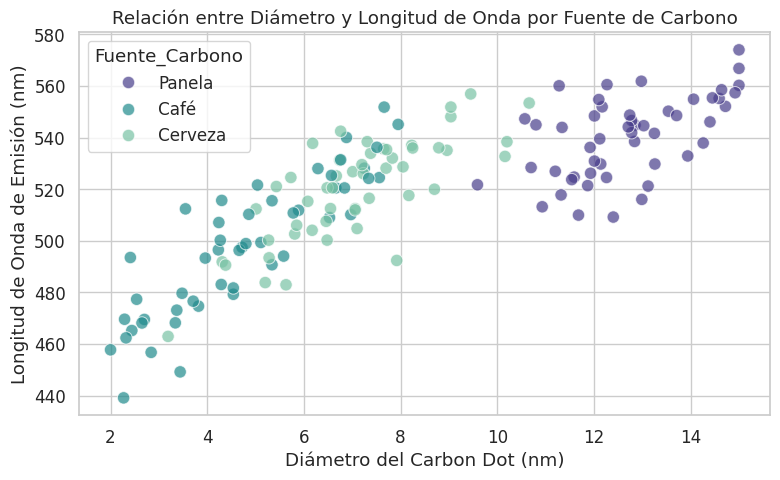

In [63]:
# --------------------------------------------------------
# Scatterplot - Sin colores por grupo
# --------------------------------------------------------
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=df,
    x='Diametro_CD',
    y='Longitud_Onda_Emision',
    color="#2A73CC",
    s=80,
    alpha=0.7
)
plt.title('Relación entre Diámetro y Longitud de Onda (Global)')
plt.xlabel('Diámetro del Carbon Dot (nm)')
plt.ylabel('Longitud de Onda de Emisión (nm)')
plt.tight_layout()
plt.show()

# --------------------------------------------------------
# Scatterplot - Coloreado por grupo
# --------------------------------------------------------
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=df,
    x='Diametro_CD',
    y='Longitud_Onda_Emision',
    hue='Fuente_Carbono',
    palette=mapa_colores,
    s=80,
    alpha=0.7
)
plt.title('Relación entre Diámetro y Longitud de Onda por Fuente de Carbono')
plt.xlabel('Diámetro del Carbon Dot (nm)')
plt.ylabel('Longitud de Onda de Emisión (nm)')
plt.tight_layout()
plt.show()


En estos gráficos podemos observar:

- Una **tendencia creciente** entre el diámetro y la longitud de onda de emisión, confirmando el efecto de confinamiento cuántico en los Carbon Dots.
- Cuando coloreamos por grupo, es posible detectar si alguna fuente de carbono produce partículas con características diferentes.
- La dispersión vertical indica la variabilidad natural del proceso de síntesis.

Este tipo de gráficos es fundamental en bioingeniería para analizar simultáneamente múltiples propiedades físicas o químicas de materiales.


### **3.6 Scatterplot Matrix**

Un **scatterplot matrix** (o matriz de gráficos de dispersión) es una excelente herramienta para visualizar simultáneamente las relaciones entre todas las variables numéricas de un conjunto de datos.

En el contexto de los Carbon Dots, nos permite observar:

- Correlaciones fuertes o débiles entre pares de variables.
- Patrones no lineales.
- Agrupaciones o clusters según las diferentes fuentes de carbono.
- Posibles outliers multivariantes.

Primero lo haremos sin colorear los puntos, para ver la nube de datos global, y luego aplicaremos colores por grupo para analizar diferencias entre precursores.


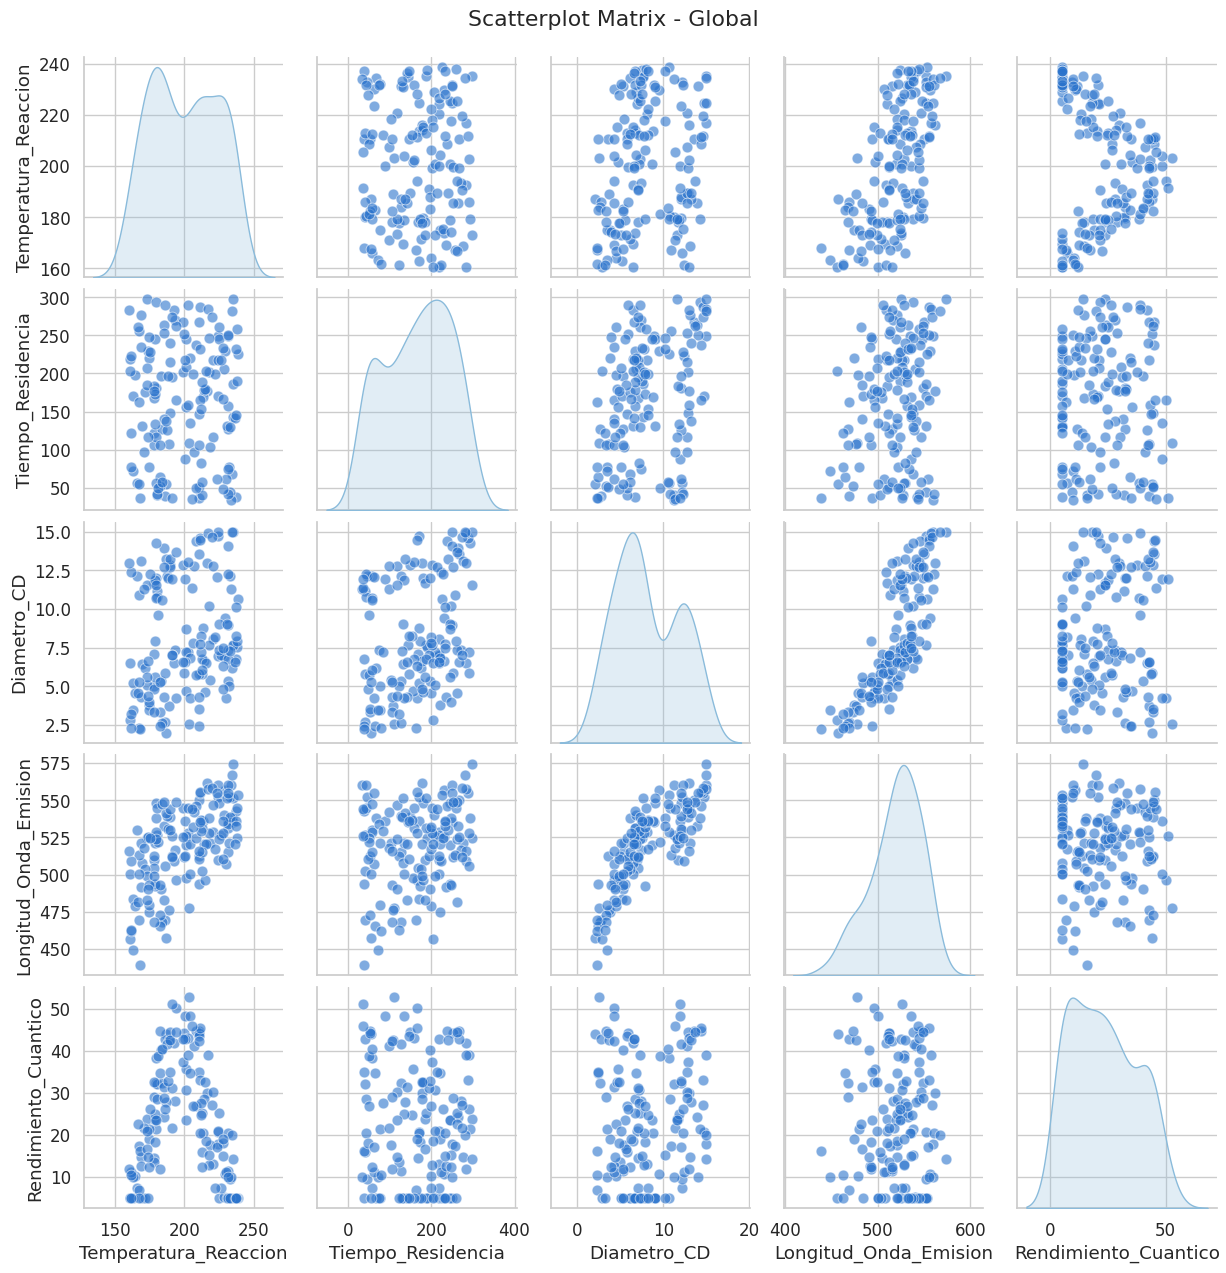

In [64]:
# --------------------------------------------------------
# Scatterplot Matrix - Sin color
# --------------------------------------------------------
sns.pairplot(
    df[variables_numericas],
    diag_kind='kde',
    plot_kws={'alpha':0.6, 's':60, 'color':'#2A73CC'}
)
plt.suptitle('Scatterplot Matrix - Global', y=1.02)
plt.show()


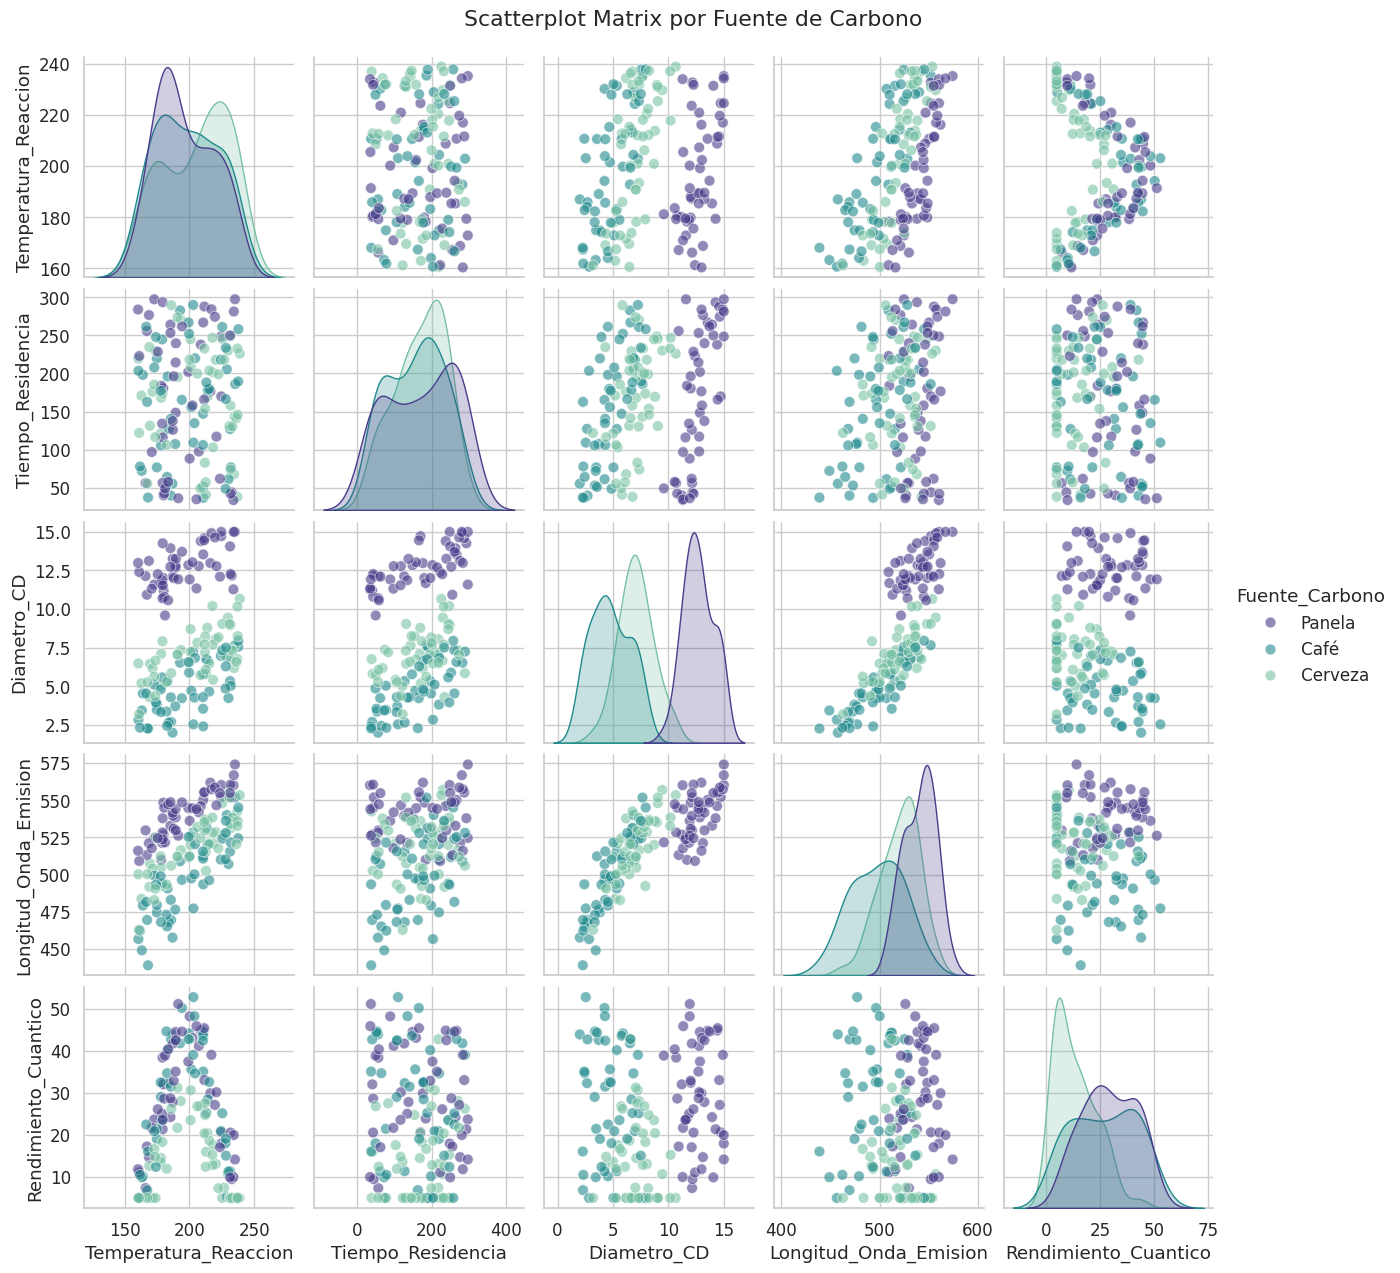

In [65]:
# --------------------------------------------------------
# Scatterplot Matrix - Con color por grupo
# --------------------------------------------------------
sns.pairplot(
    df,
    vars=variables_numericas,
    hue='Fuente_Carbono',
    diag_kind='kde',
    palette=mapa_colores,
    plot_kws={'alpha':0.6, 's':60}
)
plt.suptitle('Scatterplot Matrix por Fuente de Carbono', y=1.02)
plt.show()


En estas matrices podemos observar:

- Relaciones claras entre el **diámetro** y la **longitud de onda**, confirmando el efecto físico de confinamiento cuántico.
- Posibles agrupaciones de datos cuando coloreamos por grupo, lo que sugiere diferencias en las características de los Carbon Dots según el precursor.
- Patrones no lineales que podrían no ser detectados por las simples correlaciones numéricas.

Los scatterplot matrix son una herramienta fundamental en el análisis exploratorio multivariante, especialmente en bioingeniería, donde solemos trabajar con múltiples variables simultáneamente.


### **3.7 Bagplot (Simulado)**

Un **bagplot** es una extensión bivariada del boxplot. En lugar de mostrar la distribución de una sola variable, nos permite visualizar la forma, el centro y los posibles **outliers** de un conjunto de datos en dos dimensiones simultáneamente.

Conceptos clave:

- **Bag (Bolsa):** Región que encierra el 50% central de los datos.
- **Fence (Cerca):** Área inflada alrededor del bag para detectar outliers bivariantes.
- **Profundidad de Tukey:** Mide qué tan “central” es un punto en la nube de datos.

Actualmente Python no tiene una función directa para crear bagplots. Por eso, en esta sesión **simularemos un bagplot** dibujando una elipse de confianza alrededor de la nube de puntos de nuestros Carbon Dots.

Esto nos permitirá:

- Ver el centro y la forma general de la distribución bivariada.
- Detectar posibles outliers bivariantes.
- Visualizar patrones que no se ven en gráficos univariantes.


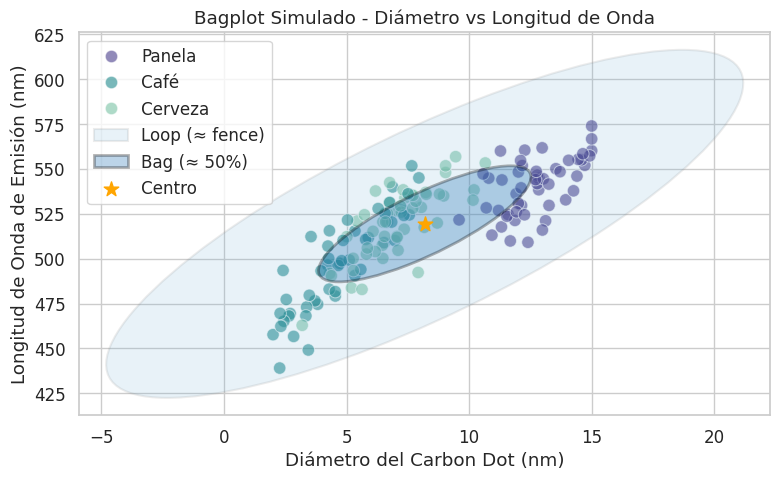

In [ ]:
import matplotlib as mpl
from matplotlib.patches import Ellipse

# --------------------------------------------------------
# Bagplot simulado con doble sombreado
# --------------------------------------------------------

# Extraer datos
X = df[['Diametro_CD', 'Longitud_Onda_Emision']].values

# Calcular media y covarianza
mu = X.mean(axis=0)
cov = np.cov(X.T)

# Función para graficar elipse con relleno opcional
def plot_cov_ellipse(cov, pos, nstd=1.0, ax=None, **kwargs):
    from scipy.stats import chi2
    import matplotlib.transforms as transforms

    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    angle = np.degrees(np.arctan2(*eigvecs[:,0][::-1]))

    chi2_val = chi2.ppf(0.5, 2) * nstd**2
    width, height = 2 * np.sqrt(eigvals * chi2_val)

    ellip = Ellipse(xy=pos, width=width, height=height,
                    angle=angle, **kwargs)
    ax = ax or plt.gca()
    ax.add_patch(ellip)
    return ellip

# Crear figura
fig, ax = plt.subplots(figsize=(8,5))

# Graficar puntos
sns.scatterplot(
    data=df,
    x='Diametro_CD', # Data_Value
    y='Longitud_Onda_Emision', # CholesterolLDL
    hue='Fuente_Carbono', # LocationDesc
    palette=mapa_colores,
    alpha=0.6,
    s=80,
    ax=ax
)

# Loop (zona intermedia - fence) → elipse más grande, relleno azul claro
plot_cov_ellipse(
    cov, mu, nstd=3.0, ax=ax,
    facecolor='#6BAED6',  # azul más claro
    edgecolor='gray',
    alpha=0.15,
    linewidth=1.5,
    label='Loop (≈ fence)'
)

# Bag (zona central) → elipse interna, relleno azul oscuro
plot_cov_ellipse(
    cov, mu, nstd=1.0, ax=ax,
    facecolor='#2171B5',  # azul oscuro
    edgecolor='black',
    alpha=0.3,
    linewidth=2,
    label='Bag (≈ 50%)'
)

# Centro
ax.scatter(mu[0], mu[1], c='orange', s=120, marker='*', label='Centro')

ax.set_title('Bagplot Simulado - Diámetro vs Longitud de Onda')
ax.set_xlabel('Diámetro del Carbon Dot (nm)')
ax.set_ylabel('Longitud de Onda de Emisión (nm)')
ax.legend()
plt.tight_layout()
plt.show()


### **3.8 Density Plot Bivariado**

Los **density plots bivariados** muestran cómo se distribuyen los datos en dos dimensiones, utilizando colores para indicar las zonas con mayor concentración de puntos.

Son especialmente útiles para:

- Detectar **clusters** o agrupaciones.
- Identificar regiones de baja densidad (outliers).
- Observar la forma general de la nube de datos.

En el caso de los Carbon Dots, es fundamental para analizar cómo se distribuyen conjuntamente el **diámetro** y la **longitud de onda de emisión**, variables directamente relacionadas con el efecto de confinamiento cuántico.


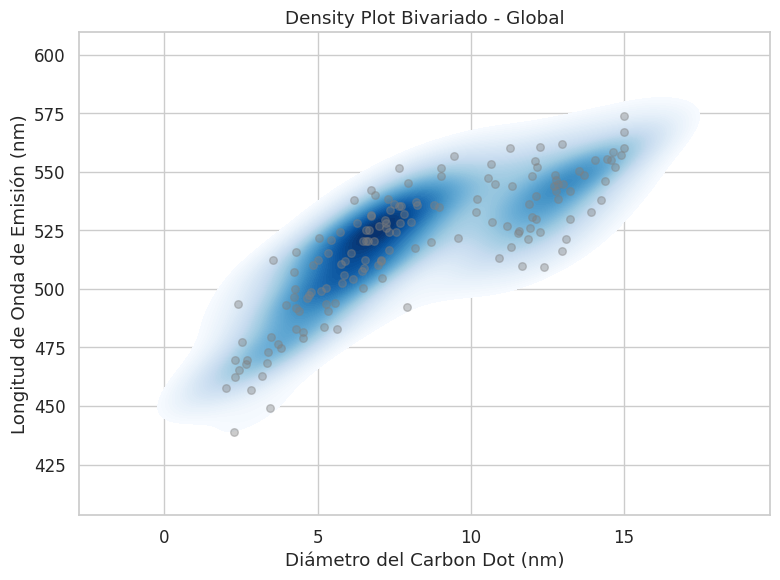

In [67]:
# --------------------------------------------------------
# Density Plot Bivariado - Global
# --------------------------------------------------------
plt.figure(figsize=(8,6))
sns.kdeplot(
    data=df,
    x='Diametro_CD',
    y='Longitud_Onda_Emision',
    fill=True,
    cmap='Blues',
    thresh=0.05,
    levels=100
)
plt.scatter(
    df['Diametro_CD'],
    df['Longitud_Onda_Emision'],
    color='gray',
    alpha=0.4,
    s=30
)
plt.title('Density Plot Bivariado - Global')
plt.xlabel('Diámetro del Carbon Dot (nm)')
plt.ylabel('Longitud de Onda de Emisión (nm)')
plt.tight_layout()
plt.show()


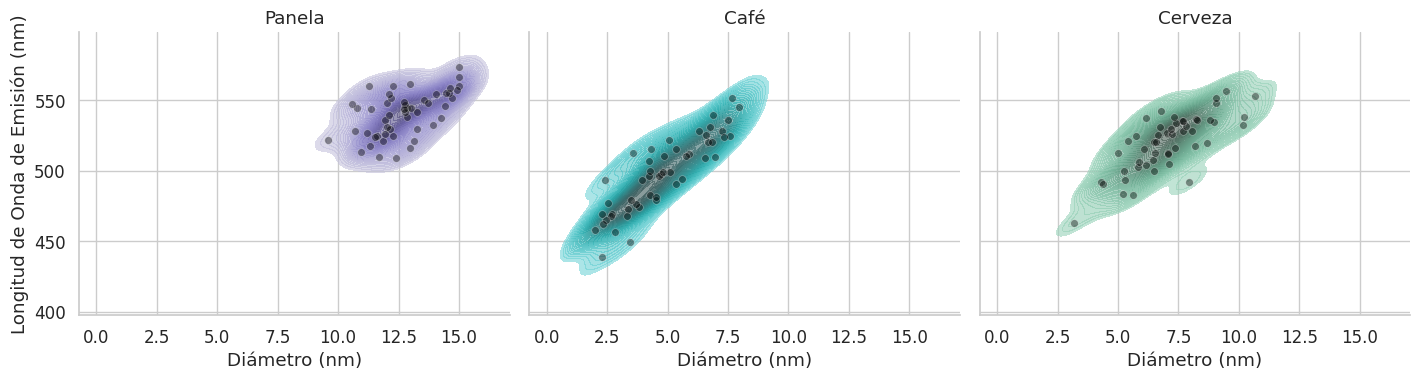

In [68]:
# --------------------------------------------------------
# Density Plot Bivariado - Facetas por Grupo
# --------------------------------------------------------
g = sns.FacetGrid(
    df,
    col='Fuente_Carbono',
    hue='Fuente_Carbono',
    palette=mapa_colores,
    height=4,
    aspect=1.2
)
g.map_dataframe(
    sns.kdeplot,
    x='Diametro_CD',
    y='Longitud_Onda_Emision',
    fill=True,
    thresh=0.05,
    levels=50,
    alpha=0.6
)
g.map_dataframe(
    sns.scatterplot,
    x='Diametro_CD',
    y='Longitud_Onda_Emision',
    color='black',
    s=30,
    alpha=0.4
)
g.set_axis_labels('Diámetro (nm)', 'Longitud de Onda de Emisión (nm)')
g.set_titles('{col_name}')
g.tight_layout()
plt.show()


En estos gráficos podemos observar:

- Las zonas donde se concentran los lotes de síntesis de Carbon Dots.
- Posibles diferencias entre las distribuciones de Panela, Café y Cerveza.
- Regiones de baja densidad, que podrían indicar outliers o experimentos con condiciones extremas.

Este tipo de gráfico es muy útil en bioingeniería, porque permite analizar simultáneamente la relación entre propiedades físicas y ópticas de los nanomateriales.


### **3.5 KDE Bivariada en 3D (Animada)**

Hemos visto la estimación de densidad kernel (KDE) bivariada en 2D. Ahora vamos a visualizarla en 3D como una superficie.

Esto nos permite ver **las zonas de mayor densidad como montañas**, dando una interpretación espacial más intuitiva.

Generaremos también un GIF animado que rota alrededor de la superficie.


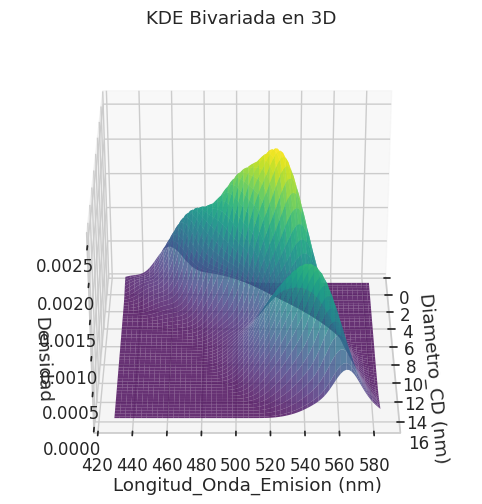

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from matplotlib import cm
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D

# Variables a usar
x_data = df['Diametro_CD'].values
y_data = df['Longitud_Onda_Emision'].values

# Creamos una grid sobre la que evaluar la densidad
x_min, x_max = x_data.min() - 1, x_data.max() + 1
y_min, y_max = y_data.min() - 10, y_data.max() + 10

X, Y = np.meshgrid(
    np.linspace(x_min, x_max, 100),
    np.linspace(y_min, y_max, 100)
)

# Empaquetamos puntos para KDE
positions = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([x_data, y_data])

# Calculamos la KDE bivariada
kernel = gaussian_kde(values, bw_method='silverman')
Z = np.reshape(kernel(positions), X.shape)

# Crear la figura 3D
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

# Surface plot inicial
surf = ax.plot_surface(
    X, Y, Z,
    cmap=cm.viridis,
    edgecolor='none',
    alpha=0.8
)

ax.set_xlabel('Diametro_CD (nm)')
ax.set_ylabel('Longitud_Onda_Emision (nm)')
ax.set_zlabel('Densidad')
ax.set_title('KDE Bivariada en 3D')

# Función para animar la rotación
def update(frame):
    ax.view_init(elev=30, azim=frame)
    return fig,

# Crear la animación
anim = animation.FuncAnimation(
    fig,
    update,
    frames=np.linspace(0, 360, 60),
    interval=100
)

# Guardar GIF
anim.save('kde_bivariada_3d.gif', writer='pillow', dpi=80)

plt.show()


Podemos observar en el gráfico 3D:

- Las **montañas más altas** representan zonas de mayor concentración de datos.
- Las zonas bajas indican **poca densidad de observaciones**.
- Visualizarlo en 3D permite entender mejor **las relaciones bivariadas** en nuestros datos.

¡Esta técnica es muy útil en bioingeniería para explorar estructuras complejas en datos experimentales!


### **3.X Parallel Coordinates (Coordenadas Paralelas)**

Las **coordenadas paralelas** son una técnica gráfica diseñada para explorar datos multivariantes. Mientras que los gráficos bivariantes nos muestran solo dos dimensiones a la vez, las coordenadas paralelas nos permiten visualizar **todas las variables numéricas de un dataset simultáneamente**.

---

#### **¿Cómo funciona un gráfico de coordenadas paralelas?**

- Cada variable del conjunto de datos se representa como un **eje vertical paralelo** a los demás.
- Cada **observación (fila)** del dataset se dibuja como una línea que conecta los valores de esa observación sobre cada eje.
- El resultado es un conjunto de “hilos” que muestran el perfil de todas las observaciones a través de las variables.

---

#### **Ventajas del gráfico de coordenadas paralelas**

- Permite detectar **patrones multivariantes**.
- Muestra:
  - Grupos de observaciones con perfiles similares.
  - Variables que tienen relaciones fuertes (por ejemplo, líneas paralelas).
  - Observaciones atípicas (líneas que se cruzan de forma distinta a la mayoría).

---

#### **Limitación principal**

Si el número de observaciones es muy grande, el gráfico puede volverse:
- **Sobrecargado visualmente**.
- Difícil de interpretar.

Una estrategia común es:
- Filtrar previamente.
- Colorear las líneas según grupos conocidos.

---

#### **Importancia en bioingeniería**

En bioingeniería, las coordenadas paralelas son extremadamente útiles para:
- Visualizar cómo varían simultáneamente variables de síntesis de materiales.
- Comparar perfiles multivariantes entre distintos **grupos experimentales**.
- Identificar muestras con perfiles inusuales que podrían indicar **nuevas propiedades materiales o fallos experimentales**.

---

#### **Nuestro caso de estudio**

Para los datos de **Carbon Dots**, queremos comparar simultáneamente:
- Temperatura de reacción
- Tiempo de residencia
- Diámetro de las partículas
- Longitud de onda de emisión
- Rendimiento cuántico

Agruparemos las líneas por la variable categórica **Fuente de Carbono**:
- Café
- Panela
- Cerveza

Así podremos ver si existen **“perfiles característicos”** para cada fuente.


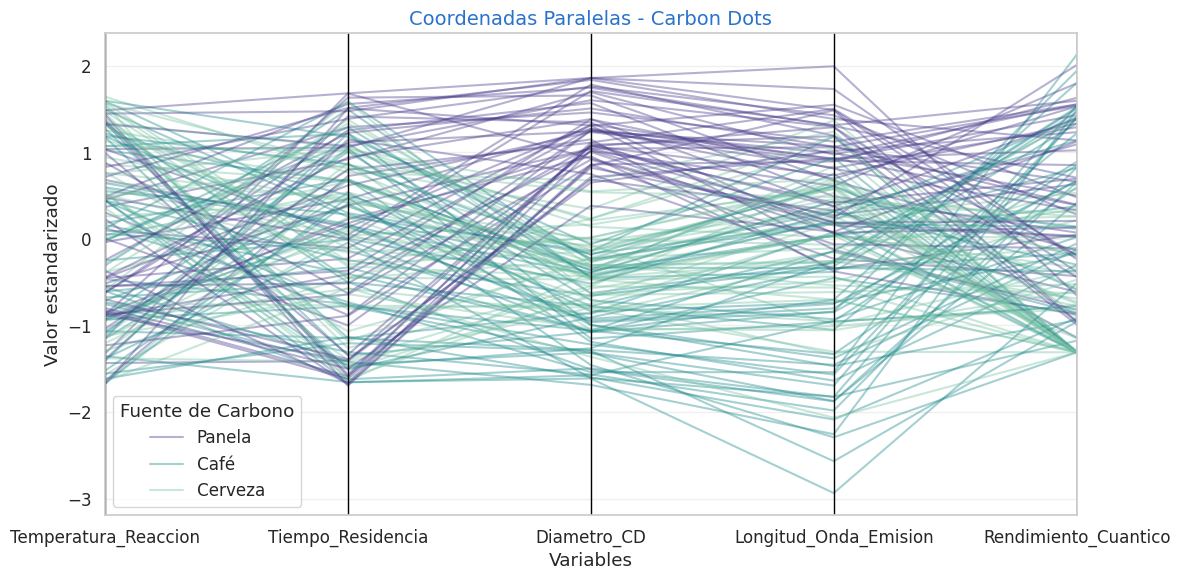

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates
from sklearn.preprocessing import StandardScaler

# --------------------------------------------------------
# Parallel Coordinates Plot - Paso a paso
# --------------------------------------------------------

# Variables numéricas que queremos visualizar
variables_numericas = [
    'Temperatura_Reaccion',
    'Tiempo_Residencia',
    'Diametro_CD',
    'Longitud_Onda_Emision',
    'Rendimiento_Cuantico'
]

# ---------------
# Paso 1: Estandarizar las variables
# ---------------
# Las coordenadas paralelas requieren que todas las variables estén
# en escalas comparables (todas entre 0 y 1 o con media cero y varianza 1).
# Si no se estandariza, las variables con valores grandes dominan visualmente.

scaler = StandardScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df[variables_numericas]),
    columns=variables_numericas
)

# Agregar la variable categórica de agrupación
df_scaled['Fuente_Carbono'] = df['Fuente_Carbono']

# ---------------
# Paso 2: Preparar colores
# ---------------
# Mapeamos los colores definidos en mapa_colores
# a cada categoría de Fuente_Carbono.

# Convertir el mapa de colores de HEX a RGB normalizado
mapa_rgb = {
    grupo: tuple(int(map_color.strip("#")[i:i+2], 16)/255.0 for i in (0, 2, 4))
    for grupo, map_color in mapa_colores.items()
}

# ---------------
# Paso 3: Graficar coordenadas paralelas
# ---------------

plt.figure(figsize=(12, 6))
parallel_coordinates(
    df_scaled,
    class_column='Fuente_Carbono',
    color=[mapa_rgb.get(grupo, (0.5, 0.5, 0.5)) for grupo in df_scaled['Fuente_Carbono'].unique()],
    alpha=0.4,
    linewidth=1.5
)

plt.title('Coordenadas Paralelas - Carbon Dots', color='#2A73CC', fontsize=14)
plt.xlabel('Variables')
plt.ylabel('Valor estandarizado')
plt.grid(alpha=0.3)
plt.legend(title='Fuente de Carbono')
plt.tight_layout()
plt.show()


Podemos observar en el gráfico:

- Las líneas que representan cada experimento de Carbon Dots siguen distintos **perfiles a través de las variables.**
- Grupos como **Panela**, **Café** y **Cerveza** podrían tener perfiles característicos:
  - Algunas líneas podrían mostrar consistentemente valores más altos o más bajos en ciertas variables.
- Las líneas que se desvían significativamente del resto podrían indicar:
  - **Experimentación con condiciones extremas.**
  - Posibles **outliers**.

En bioingeniería, estos gráficos son esenciales para **interpretar perfiles multivariantes** y detectar muestras con comportamientos inusuales que podrían ser **interesantes desde el punto de vista experimental.**


Podemos observar en el gráfico:

- Las líneas que representan cada experimento de Carbon Dots siguen distintos **perfiles a través de las variables.**
- Grupos como **Panela**, **Café** y **Cerveza** podrían tener perfiles característicos:
  - Algunas líneas podrían mostrar consistentemente valores más altos o más bajos en ciertas variables.
- Las líneas que se desvían significativamente del resto podrían indicar:
  - **Experimentación con condiciones extremas.**
  - Posibles **outliers**.

En bioingeniería, estos gráficos son esenciales para **interpretar perfiles multivariantes** y detectar muestras con comportamientos inusuales que podrían ser **interesantes desde el punto de vista experimental.**


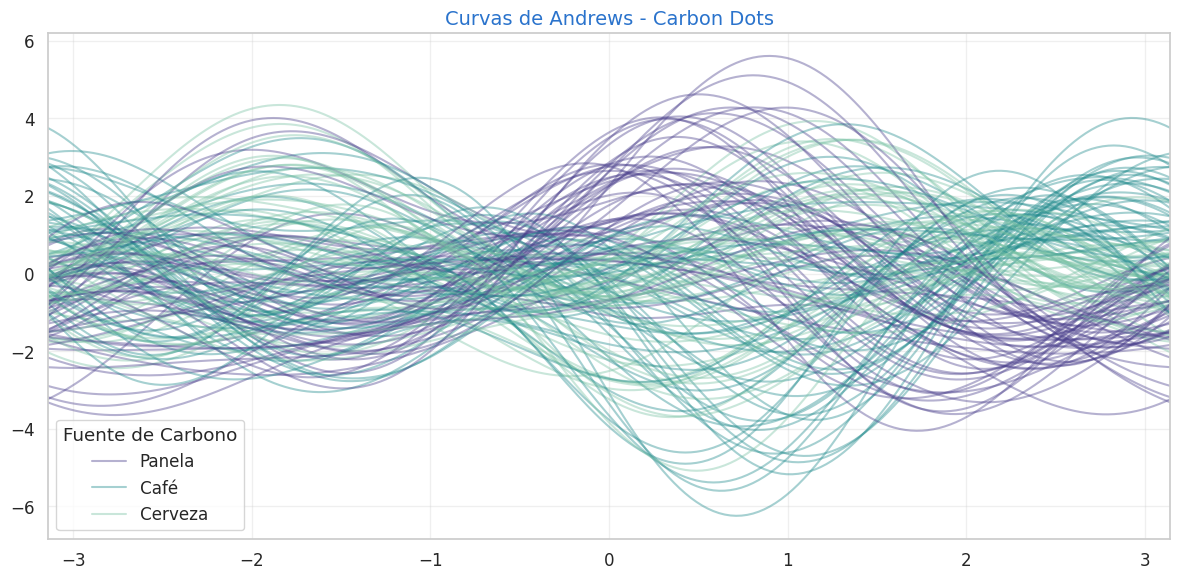

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import andrews_curves
from sklearn.preprocessing import StandardScaler

# --------------------------------------------------------
# Andrews Curves Plot - Paso a paso
# --------------------------------------------------------

# Variables numéricas que queremos visualizar
variables_numericas = [
    'Temperatura_Reaccion',
    'Tiempo_Residencia',
    'Diametro_CD',
    'Longitud_Onda_Emision',
    'Rendimiento_Cuantico'
]

# ---------------
# Paso 1: Estandarizar las variables
# ---------------
# Si no se estandarizan, las variables de gran magnitud dominan la forma de las curvas.

scaler = StandardScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df[variables_numericas]),
    columns=variables_numericas
)

# Agregar la variable categórica de agrupación
df_scaled['Fuente_Carbono'] = df['Fuente_Carbono']

# ---------------
# Paso 2: Preparar colores
# ---------------
# Convertimos el mapa de colores HEX a RGB normalizado

mapa_rgb = {
    grupo: tuple(int(map_color.strip("#")[i:i+2], 16)/255.0 for i in (0, 2, 4))
    for grupo, map_color in mapa_colores.items()
}

# ---------------
# Paso 3: Graficar Curvas de Andrews
# ---------------

plt.figure(figsize=(12, 6))
andrews_curves(
    df_scaled,
    class_column='Fuente_Carbono',
    color=[mapa_rgb.get(grupo, (0.5, 0.5, 0.5)) for grupo in df_scaled['Fuente_Carbono'].unique()],
    alpha=0.4,
    lw=1.5
)

plt.title('Curvas de Andrews - Carbon Dots', color='#2A73CC', fontsize=14)
plt.grid(alpha=0.3)
plt.legend(title='Fuente de Carbono')
plt.tight_layout()
plt.show()


Podemos observar en el gráfico:

- Cada línea representa una **observación individual** (un experimento de síntesis de Carbon Dots).
- Líneas de color similar indican observaciones provenientes de la misma **Fuente de Carbono**.
- Si las curvas de un grupo son muy **similares entre sí**, sugiere:
  - Que ese grupo tiene un **perfil multivariante consistente**.
- Si un grupo tiene curvas dispersas:
  - Indica **alta variabilidad** en sus experimentos.
- Curvas que se alejan significativamente podrían ser:
  - Posibles **outliers multivariantes**.

**Conclusión:**  
Las curvas de Andrews nos permiten explorar de manera visual la estructura multivariante de los datos, **detectar grupos naturales** y observar la variabilidad interna de cada grupo experimental.


### **3.X Radar Chart (Spider Plot)**

El **Radar Chart**, también llamado **Spider Plot**, es una técnica de visualización multivariada que representa cada observación (o promedio de grupo) como una **figura poligonal**.

---

#### **¿Cómo funciona un radar chart?**

- Cada variable del conjunto de datos se representa como un **eje radial** que se extiende desde el centro del gráfico.
- Los valores de cada observación se marcan sobre esos ejes.
- Conectando esos puntos se forma un polígono.
- Cuando se grafican múltiples observaciones o promedios de grupo, se superponen polígonos de distintos colores.

---

#### **¿Para qué sirve?**

- Comparar perfiles multivariantes **entre distintos grupos**.
- Visualizar rápidamente:
  - Qué variables destacan en cada grupo.
  - Qué grupos tienen patrones similares.
- Detectar variables responsables de las diferencias entre grupos.

---

#### **Ventajas**

- Muy intuitivo visualmente.  
- Excelente para comunicar datos multivariantes a audiencias no técnicas.  
- Resalta **perfiles promedio** de manera clara.

---

#### **Limitaciones**

- Difícil de leer con demasiadas variables.  
- Las diferencias visuales pueden ser exageradas si las escalas no son homogéneas.

---

#### **Importancia en bioingeniería**

En bioingeniería, los radar charts permiten:
- Comparar **propiedades promedio** de materiales sintetizados bajo diferentes condiciones.
- Visualizar perfiles fisiológicos o clínicos de distintos grupos de pacientes.
- Identificar patrones característicos de muestras con distintas propiedades biofísicas.

---

#### **Nuestro caso de estudio**

Para el caso de los **Carbon Dots**, vamos a crear un radar chart que muestre los **promedios de cada variable numérica**, separados por **Fuente de Carbono**:
- Café
- Panela
- Cerveza

Esto nos ayudará a responder preguntas como:
- ¿Qué fuente genera Carbon Dots más grandes en promedio?
- ¿Qué fuente tiene mayor rendimiento cuántico?


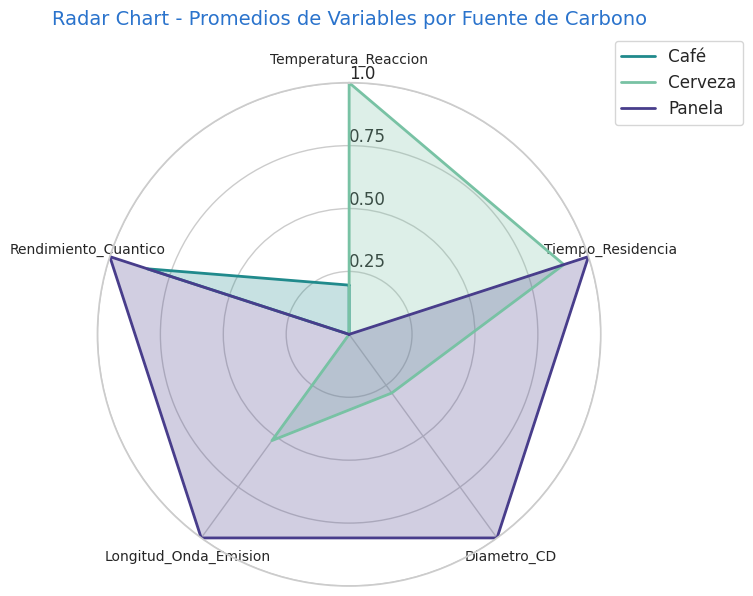

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# --------------------------------------------------------
# Radar Chart (Spider Plot) - Paso a paso
# --------------------------------------------------------

# ----------------------
# Paso 1: Calcular promedios por grupo
# ----------------------

# Variables numéricas que queremos visualizar
variables_numericas = [
    'Temperatura_Reaccion',
    'Tiempo_Residencia',
    'Diametro_CD',
    'Longitud_Onda_Emision',
    'Rendimiento_Cuantico'
]

# Calculamos promedios por Fuente_Carbono
df_means = df.groupby('Fuente_Carbono')[variables_numericas].mean()

# ----------------------
# Paso 2: Escalar los promedios
# ----------------------
# Para que todas las variables estén entre 0 y 1,
# evitando que variables grandes dominen el gráfico.

scaler = MinMaxScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df_means),
    index=df_means.index,
    columns=df_means.columns
)

# ----------------------
# Paso 3: Preparar ángulos para cada variable
# ----------------------

# Número de variables
num_vars = len(variables_numericas)

# Ángulos igualmente espaciados para cada eje
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
# Cerrar el círculo
angles += angles[:1]

# ----------------------
# Paso 4: Crear el Radar Chart
# ----------------------

# Crear la figura
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Graficar cada grupo
for grupo in df_scaled.index:
    valores = df_scaled.loc[grupo].values.flatten().tolist()
    valores += valores[:1]  # Cerrar el polígono
    ax.plot(angles, valores, linewidth=2, linestyle='solid', label=grupo, color=mapa_colores[grupo])
    ax.fill(angles, valores, alpha=0.25, color=mapa_colores[grupo])

# Configurar los ejes
ax.set_theta_offset(np.pi / 2)  # Colocar primer eje en la parte superior
ax.set_theta_direction(-1)      # Sentido horario

# Etiquetas de variables
ax.set_xticks(angles[:-1])
ax.set_xticklabels(variables_numericas, fontsize=10)

# Etiquetas de radio
ax.set_rlabel_position(0)
ax.set_yticks([0.25, 0.5, 0.75, 1.0])
ax.set_yticklabels(["0.25", "0.50", "0.75", "1.0"])
ax.set_ylim(0, 1)

# Título y leyenda
ax.set_title('Radar Chart - Promedios de Variables por Fuente de Carbono', color='#2A73CC', fontsize=14, pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.tight_layout()
plt.show()


Podemos observar en el radar chart:

- Cada polígono representa el **perfil promedio** de una fuente de Carbono en todas las variables.
- Zonas donde un grupo sobresale indican variables en las que tiene valores más altos:
  - Por ejemplo, si Panela tiene un pico pronunciado en **Rendimiento Cuántico**, sugiere mejor eficiencia luminosa.
- Formas similares entre polígonos indican grupos con perfiles parecidos.
- Formas muy distintas revelan **diferencias importantes entre grupos**.

**Conclusión:**  
El Radar Chart nos permite comparar de forma visual y rápida los **perfiles promedio multivariantes** de distintos grupos experimentales, lo cual es muy útil en bioingeniería para entender diferencias de comportamiento entre condiciones de síntesis o grupos clínicos.


### **3.X Varianza y Covarianza: Una Explicación en Profundidad**

La **varianza** y la **covarianza** son dos conceptos fundamentales en estadística multivariante. Permiten entender cómo se dispersan los datos y cómo se relacionan las variables entre sí.

---

## **Varianza muestral**

#### **¿Qué es la varianza?**

La varianza mide **la dispersión de una variable** alrededor de su media.

En otras palabras:
- Si la varianza es **baja**, los valores están muy cerca de la media.
- Si la varianza es **alta**, los valores se dispersan mucho alrededor de la media.

La fórmula de la **varianza muestral** es:

$$
s^2 = \frac{1}{n-1} \sum_{i=1}^{n} (x_i - \bar{x})^2
$$

donde:
- $x_i$ = valores observados.
- $\bar{x}$ = media muestral.
- $n$ = número de observaciones.

---

### **Interpretación geométrica**

- La varianza representa el **promedio de las distancias al cuadrado** entre cada dato y la media.
- Se expresa en **unidades cuadradas** (e.g. nm² si medimos tamaño de partículas).

**Ejemplo en bioingeniería:**

- Si medimos el diámetro de Carbon Dots:
  - Varianza pequeña → todos los Carbon Dots son muy parecidos en tamaño.
  - Varianza grande → los Carbon Dots tienen tamaños muy dispares.

---

## **Desviación típica (o estándar)**

La varianza se mide en unidades al cuadrado, lo que a veces no es intuitivo. Por eso, usamos la **desviación típica (o estándar)**:

$$
s = \sqrt{s^2}
$$

- La desviación típica se expresa en las **mismas unidades** que los datos originales.
- Es más fácil de interpretar.

---

## **Covarianza muestral**

#### **¿Qué es la covarianza?**

La covarianza mide **cómo dos variables cambian juntas.**

Matemáticamente:

$$
\mathrm{Cov}(X, Y) = \frac{1}{n - 1} \sum_{i=1}^{n} (x_i - \bar{x})(y_i - \bar{y})
$$

Interpretación:
- Si $\mathrm{Cov}(X, Y) > 0$:
  - Las dos variables tienden a **aumentar o disminuir juntas.**
- Si $\mathrm{Cov}(X, Y) < 0$:
  - Una variable aumenta mientras la otra disminuye.
- Si $\mathrm{Cov}(X, Y) = 0$:
  - No existe **relación lineal** aparente entre ellas.

---

### **Ejemplo intuitivo**

Imagina:

- $X$ = tamaño de Carbon Dots.
- $Y$ = longitud de onda de emisión.

Si **Carbon Dots más grandes** emiten a **longitudes de onda más largas**, la covarianza entre $X$ y $Y$ será **positiva**.

---

### **Limitación de la covarianza**

- Sus valores **dependen de las unidades de medida.**

Ejemplo:
- Si medimos el diámetro en nm → la covarianza tendrá unidades $\text{nm} \times \text{nm}$.
- Si medimos en μm → la covarianza cambia.

Por eso, para estandarizar las relaciones, usamos la **correlación**, que no tiene unidades y siempre está entre -1 y 1.

---

## **Matriz de varianzas y covarianzas**

Cuando tenemos más de dos variables, organizamos todas las varianzas y covarianzas en una **matriz**:

$$
\mathbf{S} =
\begin{pmatrix}
s_{11} & s_{12} & \cdots & s_{1p} \\
s_{21} & s_{22} & \cdots & s_{2p} \\
\vdots & \vdots & \ddots & \vdots \\
s_{p1} & s_{p2} & \cdots & s_{pp}
\end{pmatrix}
$$

- $s_{jj}$ = varianza de la variable $j$.
- $s_{jk}$ = covarianza entre las variables $j$ y $k$.

---

### **Interpretación geométrica**

- La matriz $\mathbf{S}$ **describe la forma de la nube de puntos multivariantes.**
- Determina:
  - **La orientación** de la nube (ejes principales).
  - **La magnitud de la dispersión** en cada dirección.

En bioingeniería, entender la matriz de covarianzas ayuda a:

- **Detectar variables redundantes.**
- Identificar **patrones conjuntos** en las propiedades físicas o químicas de materiales.
- Preparar datos para análisis como PCA (reducción de dimensiones).

---

## **Covarianza vs Correlación**

- La covarianza indica **dirección** y **magnitud** de la relación.
- La correlación estandariza la relación entre -1 y +1:

$$
\rho_{X, Y} = \frac{\mathrm{Cov}(X, Y)}{s_X \cdot s_Y}
$$

- Si $\rho = 1$ → relación perfectamente positiva.
- Si $\rho = -1$ → relación perfectamente negativa.
- Si $\rho = 0$ → ausencia de relación lineal.

---

### **En resumen**

- La varianza mide la **dispersión** de una sola variable.  
- La covarianza mide **cómo dos variables cambian juntas**.  
- La matriz de varianzas-covarianzas es la base para todo análisis multivariante.


In [73]:
# --------------------------------------------------------
# Ejemplo práctico - Estimadores multivariantes
# --------------------------------------------------------

import numpy as np

# Variables numéricas de interés
variables_numericas = [
    'Temperatura_Reaccion',
    'Tiempo_Residencia',
    'Diametro_CD',
    'Longitud_Onda_Emision',
    'Rendimiento_Cuantico'
]

# -------------------------------
# Vector de medias muestrales
# -------------------------------
media_vector = df[variables_numericas].mean()
print("=== VECTOR DE MEDIAS MUESTRALES ===")
print(media_vector.round(2))

# -------------------------------
# Matriz de varianzas y covarianzas
# -------------------------------
cov_matrix = df[variables_numericas].cov()
print("\n=== MATRIZ DE VARIANZAS Y COVARIANZAS ===")
print(cov_matrix.round(2))

# -------------------------------
# Matriz de correlaciones
# -------------------------------
corr_matrix = df[variables_numericas].corr()
print("\n=== MATRIZ DE CORRELACIONES ===")
print(corr_matrix.round(2))


=== VECTOR DE MEDIAS MUESTRALES ===
Temperatura_Reaccion     200.11
Tiempo_Residencia        166.28
Diametro_CD                8.19
Longitud_Onda_Emision    519.47
Rendimiento_Cuantico      23.26
dtype: float64

=== MATRIZ DE VARIANZAS Y COVARIANZAS ===
                       Temperatura_Reaccion  Tiempo_Residencia  Diametro_CD  \
Temperatura_Reaccion                 562.11               7.41        16.72   
Tiempo_Residencia                      7.41            6128.35        89.09   
Diametro_CD                           16.72              89.09        13.54   
Longitud_Onda_Emision                398.11             509.10        81.64   
Rendimiento_Cuantico                 -54.13             -60.97         6.47   

                       Longitud_Onda_Emision  Rendimiento_Cuantico  
Temperatura_Reaccion                  398.11                -54.13  
Tiempo_Residencia                     509.10                -60.97  
Diametro_CD                            81.64                  6.

## **3.X Medidas de Forma: Asimetría y Curtosis**

Además de saber dónde están los datos (localización) y qué tan dispersos están (dispersión), es importante saber **cómo es la forma de la distribución.**

Las dos medidas clásicas de forma son:

- **Asimetría (Skewness)**  
- **Curtosis (Kurtosis)**

---

### **Asimetría (Skewness)**

La **asimetría** indica si los datos están **desbalanceados hacia un lado u otro** respecto a la media.

#### Definición:

La asimetría muestral se calcula así:

$$
\text{Skewness} = \frac{\frac{1}{n} \sum_{i=1}^{n} (x_i - \bar{x})^3}{s^3}
$$

- Si $\text{Skewness} > 0$ → **asimetría positiva**:
  - La distribución tiene una cola más larga hacia la derecha.
- Si $\text{Skewness} < 0$ → **asimetría negativa**:
  - La distribución tiene una cola más larga hacia la izquierda.
- Si $\text{Skewness} \approx 0$ → distribución **simétrica**.

---

#### Ejemplo bioingeniería:

En datos de bioingeniería:
- Una variable como **rendimiento cuántico** podría tener asimetría positiva si la mayoría de experimentos tienen valores bajos y solo algunos casos alcanzan valores muy altos.

---

### **Curtosis (Kurtosis)**

La **curtosis** mide cuánto se concentran los datos en el centro o en las colas de la distribución.

#### Definición:

La curtosis muestral se define como:

$$
\text{Kurtosis} = \frac{\frac{1}{n} \sum_{i=1}^{n} (x_i - \bar{x})^4}{s^4}
$$

- Si $\text{Kurtosis} > 3$ → **Leptocúrtica**:
  - Distribución con picos muy altos y colas más pesadas que la normal.
- Si $\text{Kurtosis} < 3$ → **Platicúrtica**:
  - Distribución más “aplanada” que la normal.
- Si $\text{Kurtosis} = 3$ → **Mesocúrtica**:
  - Igual que la distribución normal.

Muchas bibliotecas reportan **exceso de curtosis**, que es simplemente:

$$
\text{Exceso de curtosis} = \text{Kurtosis} - 3
$$

Así, para una distribución normal, el exceso de curtosis es cero.

---

#### Ejemplo bioingeniería:

- Un material cuya propiedad física sea muy estable en la mayoría de muestras, pero que ocasionalmente tenga valores extremos, presentará **alta curtosis**.

---

### **¿Por qué importa la forma?**

> Permite detectar:
- Outliers.
- Necesidad de transformaciones.
- No normalidad de los datos.

> Fundamental en bioingeniería:
- Para validar supuestos estadísticos.
- Para entender la variabilidad de los procesos experimentales.

---

En resumen:

> **Asimetría y curtosis son claves para describir la forma de las distribuciones y anticipar problemas o interpretaciones erróneas en análisis estadísticos.**


In [74]:
# --------------------------------------------------------
# Ejemplo práctico - Asimetría y Curtosis
# --------------------------------------------------------

from scipy.stats import skew, kurtosis

# Variables numéricas
variables_numericas = [
    'Temperatura_Reaccion',
    'Tiempo_Residencia',
    'Diametro_CD',
    'Longitud_Onda_Emision',
    'Rendimiento_Cuantico'
]

print("=== ASIMETRÍA (Skewness) ===")
for var in variables_numericas:
    skew_val = skew(df[var])
    print(f"{var}: {skew_val:.3f}")

print("\n=== CURTOSIS (Kurtosis) ===")
for var in variables_numericas:
    kurt_val = kurtosis(df[var], fisher=False) # Fisher=False → kurtosis normal = 3
    print(f"{var}: {kurt_val:.3f}")


=== ASIMETRÍA (Skewness) ===
Temperatura_Reaccion: 0.032
Tiempo_Residencia: -0.166
Diametro_CD: 0.260
Longitud_Onda_Emision: -0.594
Rendimiento_Cuantico: 0.274

=== CURTOSIS (Kurtosis) ===
Temperatura_Reaccion: 1.702
Tiempo_Residencia: 1.838
Diametro_CD: 1.884
Longitud_Onda_Emision: 2.854
Rendimiento_Cuantico: 1.872


## **3.X Profundidad Multivariante (Depth)**

Cuando tenemos datos multivariantes, surge la pregunta:

> **¿Cómo definimos el “centro” de un conjunto de datos en varias dimensiones?**

En datos univariantes, es sencillo:
- El centro suele ser la **media** o la **mediana**.

Pero en varias dimensiones, la media puede no ser suficientemente robusta:
- Puede verse muy afectada por outliers.
- No refleja bien la estructura geométrica de los datos.

---

### **¿Qué es la profundidad (depth)?**

La **profundidad multivariante** es una forma de medir **qué tan central es un punto dentro de un conjunto de datos multivariantes.**

- Se basa en contar **cuántos puntos quedan “alrededor” de un punto candidato.**
- Cuanto mayor es la profundidad, más central es el punto.
- Los puntos con mayor profundidad forman el “centro” de la nube de datos.

---

### **Halfspace Depth (Tukey Depth)**

Una de las definiciones más conocidas es la **Halfspace Depth** (o **Tukey Depth**):

- La profundidad de un punto $x$ es el **mínimo número de observaciones** que se encuentran en un lado de cualquier semiplano (halfspace) que pase por $x$.

Intuitivamente:
- Si colocamos una recta (en 2D) o un plano (en 3D) pasando por el punto $x$, ¿cuál es el mínimo número de puntos que quedan en un lado?
- Cuanto mayor sea ese mínimo, más central es el punto.

---

#### **Propiedades de la profundidad**

 Cuantifica “centralidad.”  
 Es robusta a outliers.  
 Permite definir conceptos como:
- **Median multivariante** → el punto de mayor profundidad.
- **Regiones centrales** → zonas que contienen cierta proporción de datos.

---

### **Profundidad y Bagplot**

El **bagplot** es un gráfico multivariante que:
- Usa la **mediana multivariante** como centro.
- Dibuja regiones basadas en profundidad:
  - El **bag** → zona que contiene el 50% de mayor profundidad.
  - El **loop** → zona expandida para detectar outliers.

Por eso:
> **La profundidad es la base matemática detrás del bagplot.**

---

#### **Importancia en bioingeniería**

En bioingeniería, las medidas de profundidad multivariante son clave para:

- Encontrar el “centro” real de poblaciones experimentales.
- Detectar observaciones multivariantes extremas (outliers).
- Analizar datos en contextos donde las distribuciones no son normales o tienen colas pesadas.

---

### **Relación con Mahalanobis Distance**

- Mahalanobis distance también mide **qué tan lejos está un punto del centro multivariante.**
- Pero depth es más robusto, porque:
  - No supone normalidad.
  - Es menos sensible a outliers extremos.

---

En resumen:

> **La profundidad multivariante permite definir el centro y las regiones de datos en espacios multidimensionales, superando limitaciones de la media y siendo fundamental para técnicas robustas como el bagplot.**


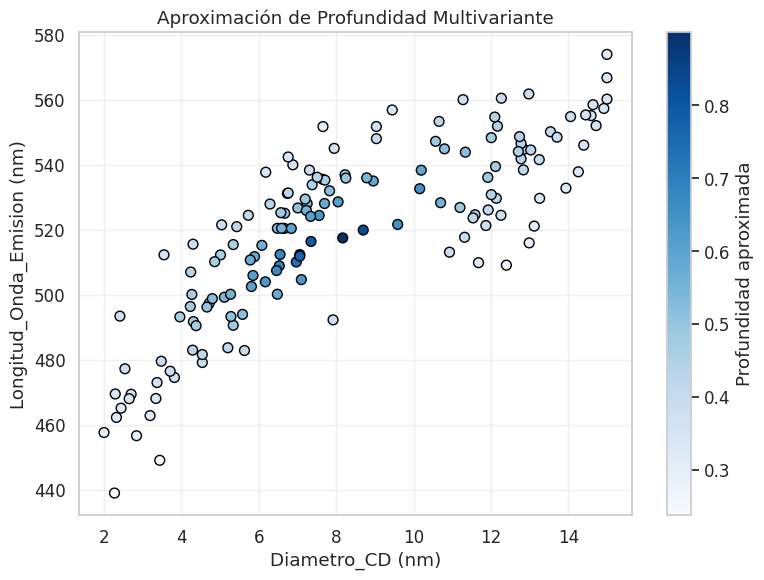

In [75]:
# --------------------------------------------------------
# Ejemplo práctico - Profundidad aproximada usando Mahalanobis distance
# --------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance

# Variables numéricas
vars_2d = ['Diametro_CD', 'Longitud_Onda_Emision']

# Datos en 2D
data = df[vars_2d].values

# Calcular media multivariada
mean_vec = np.mean(data, axis=0)

# Calcular matriz de covarianzas
cov_mat = np.cov(data, rowvar=False)

# Calcular distancia Mahalanobis de cada punto al centro
inv_covmat = np.linalg.inv(cov_mat)
mahal_distances = np.array([
    distance.mahalanobis(x, mean_vec, inv_covmat)
    for x in data
])

# Convertir Mahalanobis a "profundidad inversa"
# (solo como ilustración, no es Tukey depth real)
depth_approx = 1 / (1 + mahal_distances)

# Plot en scatter
plt.figure(figsize=(8,6))
plt.scatter(
    data[:,0],
    data[:,1],
    c=depth_approx,
    cmap='Blues',
    s=50,
    edgecolor='black'
)
plt.colorbar(label='Profundidad aproximada')
plt.xlabel('Diametro_CD (nm)')
plt.ylabel('Longitud_Onda_Emision (nm)')
plt.title('Aproximación de Profundidad Multivariante')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


**Interpretación del gráfico:**

- Los puntos más oscuros tienen **mayor profundidad** → están más cerca del centro multivariante.
- Los puntos más claros tienen **menor profundidad** → están más alejados.
- Aunque esto **no es Tukey depth exacto**, nos da una intuición visual:
  - Qué puntos son más centrales.
  - Qué puntos podrían considerarse **outliers multivariantes.**

En bioingeniería, esto es esencial para:
- Detectar experimentos con perfiles multivariantes inusuales.
- Definir regiones de confianza en espacios multivariantes.
